In [1]:
import sys
sys.path.insert(0, "../source/")
import pyomo
import numpy as np
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import cyipopt
import pyomo.environ as pyenv
from scipy.integrate import RK45

In [ ]:
# polygon obstacle
class polygon_obstacle:
    def __init__(self, vertices):
        """
        :param vertices:  polygon vertices in clockwise order
        """
        self.vertices = np.array(vertices)

    def unit_vec(self, vector):
        return vector/np.linalg.norm(vector)

    @property
    def side_vectors(self):
        """Unit vectors along perimeter of polygon"""
        return np.array([
            self.unit_vec(self.vertices[i] - self.vertices[i - 1]) for i in range(len(self.vertices))
        ])

    @property
    def orthogonal_vectors(self):
        """Unit normal vectors for polygon sides"""
        return np.array([
            np.array([-v[1], v[0]]) for v in self.side_vectors
        ])

    @property
    def constants(self):
        """
        orthogonal . x >= constant
        """
        return np.array([
            np.dot(vertex, v) for vertex, v in zip(self.vertices, self.orthogonal_vectors)
        ])

polygon = polygon_obstacle([[0, 0], [1, 1.5], [1, 0]])

x = np.linspace(-1, 2, 1000)
y = np.linspace(-1, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
for v, c in zip(polygon.orthogonal_vectors, polygon.constants):
    Z += (v[0]*X + v[1]*Y >= c)
plt.figure()
plt.imshow(Z)
plt.colorbar()

# Pyomo DAE

In [ ]:
model = pyenv.ConcreteModel()

x0 = 0.8
y0 = 0.7
theta0 = 0.0
x_final = 0.0
y_final = 0.0
theta_final = np.pi

M = 10

regularization = 0.1

# Obstacles
cxs = [0.5, 0.4, 0.0]
cys = [0.5, 0.0, 0.1]
rs = [0.25, 0.15, 0.09]
obstacle_shape = "circle"

# bounds
x_lower = 0
x_upper = 1
y_lower = 0
y_upper = 1
v_lower = 0.0
v_upper = 1
acc_lower = -10
acc_upper = 10
omega_lower = -100*np.pi
omega_upper = 100*np.pi
omega_acc_lower = -100
omega_acc_upper = 100

model.T = 4  # final time
model.NK = 100  # number of time steps
model.h = model.T/model.NK  # time grid spacing
model.K = pyenv.RangeSet(model.NK)
model.K0 = pyenv.RangeSet(0, model.NK)
model.Km1 = pyenv.RangeSet(model.NK - 1)  # [1, NK - 1]
model.K0m1 = pyenv.RangeSet(0, model.NK - 1)  # [1, NK - 1]
model.K0m2 = pyenv.RangeSet(0, model.NK - 2)  # [1, NK - 1]

# Initial path
initial_x = np.linspace(x0, 0.0, model.NK)
initial_y = np.linspace(y0, 0.0, model.NK)
initial_theta = np.linspace(0.2, 0.5, model.NK)
initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = np.ones(initial_x.shape)

# # Use previously solved path
# initial_x = x
# initial_y = y
# initial_theta = theta
# initial_v = v
# initial_omega = omega

model.x = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(x_lower, x_upper), initialize=dict(zip(model.K0, initial_x))) # p(t)_x
model.y = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(y_lower, y_upper), initialize=dict(zip(model.K0, initial_y))) # p(t)_y
model.theta = pyenv.Var(model.K0m1, domain=pyenv.Reals)  # theta can be unbounded, arctan(dy/dx)
model.v = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(v_lower, v_upper), initialize=dict(zip(model.K0, initial_v))) # velocity; control parameter
model.acc = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(acc_lower, acc_upper), initialize=dict(zip(model.K0m1, np.diff(initial_v)))) # acceleration; control parameter
model.omega = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(omega_lower, omega_upper)) # angular velocity; control parameter
model.omega_acc = pyenv.Var(model.K0m1, domain=pyenv.Reals, bounds=(omega_acc_lower, omega_acc_upper)) # angular acceleration; control parameter

def x_forward_Euler(model, k):
    return model.x[k + 1] - model.x[k] == model.h * model.v[k] * pyenv.cos(model.theta[k])
model.x_forward_Euler = pyenv.Constraint(model.K0m2, rule=x_forward_Euler)

def y_forward_Euler(model, k):
    return model.y[k + 1] - model.y[k] == model.h * model.v[k] * pyenv.sin(model.theta[k])
model.y_forward_Euler = pyenv.Constraint(model.K0m2, rule=y_forward_Euler)

def theta_forward_Euler(model, k):
    return model.theta[k + 1] - model.theta[k] == model.h * model.omega[k]
model.theta_forward_Euler = pyenv.Constraint(model.K0m2, rule=theta_forward_Euler)

def acceleration_forward_Euler(model, k):
    return model.v[k + 1] - model.v[k] == model.h * model.acc[k]
model.acceleration_forward_Euler = pyenv.Constraint(model.K0m2, rule=acceleration_forward_Euler)

def omega_acceleration_forward_Euler(model, k):
    return model.omega[k + 1] - model.omega[k] == model.h * model.omega_acc[k]
model.omega_acceleration_forward_Euler = pyenv.Constraint(model.K0m2, rule=omega_acceleration_forward_Euler)

def initial_x_rule(model):
    return model.x[0] == x0
model.initial_x_rule = pyenv.Constraint(rule=initial_x_rule)

def initial_y_rule(model):
    return model.y[0] == y0
model.initial_y_rule = pyenv.Constraint(rule=initial_y_rule)

def initial_theta_rule(model):
    return model.theta[0] == theta0
# model.initial_theta_rule = pyenv.Constraint(rule=initial_theta_rule)

def final_x_rule(model):
    return model.x[model.NK-1] == x_final
model.final_x_rule = pyenv.Constraint(rule=final_x_rule)

def final_y_rule(model):
    return model.y[model.NK-1] == y_final
model.final_y_rule = pyenv.Constraint(rule=final_y_rule)

# Allow for +- 2*pi
def final_theta_sin_rule(model):
    return pyenv.sin(model.theta[model.NK]) == pyenv.sin(theta_final)

def final_theta_cos_rule(model):
    return pyenv.cos(model.theta[model.NK]) == pyenv.cos(theta_final)
# model.final_theta_sin_rule = pyenv.Constraint(rule=final_theta_sin_rule)
# model.final_theta_cos_rule = pyenv.Constraint(rule=final_theta_cos_rule)

def diamond_obstacle_rule(model, k, cx, cy, r):
    """1-norm obstacle with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return abs(model.x[k] - cx)/rx +  abs(model.y[k] - cy)/ry >= 1

def square_obstacle_rule(model, k, cx, cy, r):
    """1-norm obstacle rotated with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return 0.5*abs((model.x[k]-cx)/rx + (model.y[k]-cy)/ry) +  0.5*abs((model.x[k]-cx)/rx - (model.y[k]-cy)/ry) >= 1

def circle_obstacle_rule(model, k, cx, cy, r):
    """Circle obstacle with center (cx, cy) and radius r"""
    rx = r
    ry = r
    return (model.x[k] - cx)**2/(rx**2) + (model.y[k] - cy)**2/(ry**2) >= 1

if obstacle_shape == "circle":
    model.circle_obstacle_rules = pyenv.ConstraintList()
    for k in model.K0m1:
        for cx, cy, r in zip(cxs, cys, rs):
            model.circle_obstacle_rules.add(
                circle_obstacle_rule(model, k, cx, cy, r)
            )
elif obstacle_shape == "square":
    model.square_obstacle_rules = pyenv.ConstraintList()
    for k in model.K0m1:
        for cx, cy, r in zip(cxs, cys, rs):
            model.square_obstacle_rules.add(
                square_obstacle_rule(model, k, cx, cy, r)
            )
elif obstacle_shape == "diamond":
    model.diamond_obstacle_rules = pyenv.ConstraintList()
    for k in model.K0m1:
        for cx, cy, r in zip(cxs, cys, rs):
            model.diamond_obstacle_rules.add(
                diamond_obstacle_rule(model, k, cx, cy, r)
            )

# poly1_vertices = [
#     [0.1, 0.0],
#     [0.1, 0.2],
#     [0.2, 0.2],
#     [0.2, 0.0]
# ]
# polygons = [
#     polygon_obstacle(poly1_vertices)
# ]

# model.Nvertices = pyenv.RangeSet(len(poly1_vertices))
# model.Y = pyenv.Var(model.Nvertices, domain=pyenv.Binary)

# model.poly_obstacle_rules = pyenv.ConstraintList()
# for poly in polygons:
#     for i, (v, c) in enumerate(zip(poly.orthogonal_vectors, poly.constants)):
#         for k in model.K:
#             model.poly_obstacle_rules.add((model.x[k]*v[0] + model.y[k]*v[1]) >= model.Y[i+1] * c - (1 - model.Y[i+1]) * M)

# def poly_obstacle_sum_rule(model):
#     return sum(model.Y[i] for i in model.Nvertices) >= 1
# model.poly_obstacle_sum_rule = pyenv.Constraint(rule = poly_obstacle_sum_rule)

def objective_func(model):
    return model.x[model.NK-1]**2 + model.y[model.NK-1]**2 + regularization/model.NK*(pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega))
    # return pyenv.sum_product(model.v, model.v) + pyenv.sum_product(model.omega, model.omega)
model.objective_func = pyenv.Objective(rule=objective_func, sense=pyenv.minimize)


solver = pyenv.SolverFactory("ipopt")
# solver.options['derivative_test'] = 'first-order'
solver.solve(model, tee=True)


In [ ]:
import matplotlib.pyplot as plt
plt.figure()

x, y, theta, v, omega = [], [], [], [], []
for k in zip(model.K0m1):
    x.append(pyenv.value(model.x[k]))
    y.append(pyenv.value(model.y[k]))
    theta.append(pyenv.value(model.theta[k]))
    v.append(pyenv.value(model.v[k]))
    omega.append(pyenv.value(model.omega[k]))
plt.plot(x, y, label="Optimized path")
plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

plt.plot(initial_x, initial_y, label="Initial path")

if obstacle_shape == "circle":
    style = 'k'
else:
    style = 'k--'
# circle
t = np.linspace(0, 2*np.pi, 100)
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot(r*np.cos(t) + cx, r*np.sin(t) + cy, style)

if obstacle_shape == "diamond":
    style = 'k'
else:
    style = 'k--'
# diamond
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot([cx, cx + r, cx, cx - r, cx], [cy + r, cy, cy - r, cy, cy + r], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, r in zip(cxs, cys, rs):
    plt.plot([cx + r, cx + r, cx - r, cx - r, cx + r], [cy -r, cy + r, cy + r, cy - r, cy - r], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

plt.legend()

plt.figure()
plt.plot(v, label="Velocity")
plt.plot(omega, label="Angular Velocity")
plt.legend()

Solution is sensitive to initial path provided. I am not sure how IPOPT handles initial values that are inconsitent with constraints.

Unfortunately, I don't see how to get the external function of the OED objective into pyomo. It might be better to interface directly with IPOPT.

# Direct IPOPT optimization: Example Rosenbrock function
If we use `cyipopt`, we can specify the objective function value and a gradient function, but we have to handle the constraints ourselves.

In [ ]:
# Define the objective function
def rosenbrock(x, user_data=None):
    x1 = x[0]
    x2 = x[1]
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

class Objective:
    def objective(self, x):
        return rosenbrock(x, user_data=None)
    def gradient(self, x):
        """Objective function gradient"""
        return jax.grad(self.objective)(x)
    def constraints(self, x):
        """Values to constrain between cl and cu"""
        return (
            (x[0] - 1)**2 + (x[1] - 1)**2,
            x[0]
        )
    def jacobian(self, x):
        """Jacobian of constraints"""
        return jax.jacfwd(self.constraints)(x)
        
problem_obj = Objective()

print(f"objective: {problem_obj.objective([1.2,1.])}\ngradient: {problem_obj.gradient([1.2,1.])}")

# Create the problem instance
problem = cyipopt.Problem(
    n=2,  # Number of decision variables
    m=2,  # Number of constraints
    problem_obj=problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = [-2.0, -2.0],  # Lower bounds for x
    ub = [2.0, 2.0],  # Upper bounds for x
    cl = [0.01, 0.0], # Lower bound for constraints
    cu = [0.01, 1.5], # Lower bound for constraints
)

# Set the initial guess for the decision variables
x0 = [2.0, 1.0]

problem.add_option("derivative_test", "first-order")
# Solve the problem
solution, info = problem.solve(x0)

# Print the solution
print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")

# HS71

In [ ]:
# Define the objective function
@jax.jit
def HockSchittkowski71(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    return x1*x4*(x1 + x2 + x3) + x3

@jax.jit
def objective(x):
    return x[0]*x[3]*jnp.sum(x[:3]) + x[2]

@jax.jit
def gradient(x):
    """Objective function gradient"""
    return jax.grad(objective)(x)

@jax.jit
def constraints(x):
    """Values to constrain between cl and cu"""
    return jnp.array((
        jnp.sum(x**2) - 40, # == 0
        jnp.prod(x) - 25, # >= 0
    ))

@jax.jit
def jacobian(x):
    """Jacobian of constraints"""
    return jax.jacfwd(constraints)(x)

class Objective:
    def objective(self, x):
        return objective(x)
    def gradient(self, x):
        return gradient(x)
    @property
    def n(self):
        return 4
    @property
    def m(self):
        return 2
    @property
    def lb(self):
        return (1,1,1,1,)
    @property
    def ub(self):
        return (5,5,5,5,)
    @property
    def x0(self):
        return jnp.array((1.0,5.0,5.0,1.0,))
    def constraints(self, x):
        return constraints(x)
    @property
    def cl(self):
        return (0,0,)
    @property
    def cu(self):
        return (0,np.inf,)
    def jacobian(self, x):
        return jacobian(x)

    # def hessian(self, x, lagrange, objective_factor):
    #     """Hessian of lagrangian"""
    #     print(jnp.sum(lagrange[:,jnp.newaxis,jnp.newaxis] * jax.jacrev(jax.jacfwd(self.constraints))(x), axis = 0))
    #     print(jax.jacrev(jax.jacfwd(self.objective))(x))
    #     print(jnp.sum(lagrange[:,jnp.newaxis,jnp.newaxis] * jax.jacrev(jax.jacfwd(self.constraints))(x), axis = 0) + objective_factor * jax.jacrev(jax.jacfwd(self.objective))(x))
    #     return jnp.sum(lagrange[:,jnp.newaxis,jnp.newaxis] * jax.jacrev(jax.jacfwd(self.constraints))(x), axis = 0) + objective_factor * jax.jacrev(jax.jacfwd(self.objective))(x)
        
        
problem_obj = Objective()

# print(f"objective: {problem_obj.objective([1.2,1.])}\ngradient: {problem_obj.gradient([1.2,1.])}")

# Create the problem instance
problem = cyipopt.Problem(
    n = problem_obj.n,  # Number of decision variables
    m = problem_obj.m,  # Number of constraints
    problem_obj=problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = problem_obj.lb,  # Lower bounds for x
    ub = problem_obj.ub,  # Upper bounds for x
    cl = problem_obj.cl, # Lower bound for constraints
    cu = problem_obj.cu, # Lower bound for constraints
)

# Set the initial guess for the decision variables
x0 = problem_obj.x0

problem_obj.jacobian(x0)
problem_obj.gradient(x0)

problem.add_option("derivative_test", "first-order")
problem.add_option("hessian_approximation", "limited-memory")
# Solve the problem
solution, info = problem.solve(x0)

# Print the solution
# print(f"Solution: {solution}")
# print(f"Objective value: {info['obj_val']}")

In [ ]:
model = pyenv.ConcreteModel()

# bounds
x_lower = 1
x_upper = 5

model.n = pyenv.RangeSet(4)

# Initial
initial_x = [1, 5, 5, 1]

model.x = pyenv.Var(model.n, domain=pyenv.Reals, bounds=(x_lower, x_upper), initialize=dict(zip(model.n, initial_x)))

def con_1(model):
    return model.x[1]**2 + model.x[2]**2 + model.x[3]**2 + model.x[4]**2 - 40 == 0 # == 0
def con_2(model):
    return model.x[1]*model.x[2]*model.x[3]*model.x[4] - 25 >= 0
model.con_1 = pyenv.Constraint(rule=con_1)
model.con_2 = pyenv.Constraint(rule=con_2)

def objective(model):
    return model.x[1]*model.x[4]*(model.x[1] + model.x[2] + model.x[3]) + model.x[3]
model.objective = pyenv.Objective(rule=objective, sense=pyenv.minimize)


solver = pyenv.SolverFactory("ipopt")
solver.options['derivative_test'] = 'first-order'
solver.options['hessian_approximation'] = 'limited-memory'
solver.solve(model, tee=True)


# HS61

In [ ]:
# Model hs61 
# x[0:2] = 0 best known objective = - 143.6461422
@jax.jit
def objective(x):
    return 4*x[0]**2 + 2*x[1]**2 + 2*x[2]**2 - 33*x[0] + 16*x[1] - 24*x[2]
@jax.jit
def constraints(x):
    return jnp.array((
        3*x[0] - 2*x[1]**2 - 7,
        4*x[0] -   x[2]**2 - 11,
    ))

@jax.jit
def gradient(x):
    """Objective function gradient"""
    return jax.grad(objective)(x)

@jax.jit
def jacobian(x):
    """Jacobian of constraints"""
    return jax.jacfwd(constraints)(x)

class Objective:
    def objective(self, x):
        return objective(x)
    def gradient(self, x):
        return gradient(x)
    @property
    def n(self):
        return 3
    @property
    def m(self):
        return 2
    @property
    def lb(self):
        # return (-np.inf,-np.inf,-np.inf,)
        return None
    @property
    def ub(self):
        # return (np.inf,np.inf,np.inf,)
        return None
    @property
    def x0(self):
        return jnp.array((0.0,0.0,0.0,))
    def constraints(self, x):
        return constraints(x)
    @property
    def cl(self):
        return (0,0,)
    @property
    def cu(self):
        return (0,0,)
    def jacobian(self, x):
        return jacobian(x)

    # def hessian(self, x, lagrange, objective_factor):
    #     """Hessian of lagrangian"""
    #     print(jnp.sum(lagrange[:,jnp.newaxis,jnp.newaxis] * jax.jacrev(jax.jacfwd(self.constraints))(x), axis = 0))
    #     print(jax.jacrev(jax.jacfwd(self.objective))(x))
    #     print(jnp.sum(lagrange[:,jnp.newaxis,jnp.newaxis] * jax.jacrev(jax.jacfwd(self.constraints))(x), axis = 0) + objective_factor * jax.jacrev(jax.jacfwd(self.objective))(x))
    #     return jnp.sum(lagrange[:,jnp.newaxis,jnp.newaxis] * jax.jacrev(jax.jacfwd(self.constraints))(x), axis = 0) + objective_factor * jax.jacrev(jax.jacfwd(self.objective))(x)
        
        
problem_obj = Objective()

# print(f"objective: {problem_obj.objective([1.2,1.])}\ngradient: {problem_obj.gradient([1.2,1.])}")

# Create the problem instance
problem = cyipopt.Problem(
    n = problem_obj.n,  # Number of decision variables
    m = problem_obj.m,  # Number of constraints
    problem_obj=problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = problem_obj.lb,  # Lower bounds for x
    ub = problem_obj.ub,  # Upper bounds for x
    cl = problem_obj.cl, # Lower bound for constraints
    cu = problem_obj.cu, # Lower bound for constraints
)

# Set the initial guess for the decision variables
x0 = problem_obj.x0

problem_obj.jacobian(x0)
problem_obj.gradient(x0)

problem.add_option("derivative_test", "first-order")
problem.add_option("hessian_approximation", "limited-memory")
# Solve the problem
solution, info = problem.solve(x0)

# Print the solution
# print(f"Solution: {solution}")
# print(f"Objective value: {info['obj_val']}")

In [ ]:
model = pyenv.ConcreteModel()

model.n = pyenv.RangeSet(3)

# Initial
initial_x = [0, 0, 0]

model.x = pyenv.Var(model.n, domain=pyenv.Reals, initialize=dict(zip(model.n, initial_x)))

def con_1(model):
    return 3*model.x[1] - 2*model.x[2]**2 == 7
def con_2(model):
    return 4*model.x[1] -   model.x[3]**2 == 11
model.con_1 = pyenv.Constraint(rule=con_1)
model.con_2 = pyenv.Constraint(rule=con_2)

def objective(model):
    return 4*model.x[1]**2 + 2*model.x[2]**2 + 2*model.x[3]**2 - 33*model.x[1] + 16*model.x[2] - 24*model.x[3]
model.objective = pyenv.Objective(rule=objective, sense=pyenv.minimize)


solver = pyenv.SolverFactory("ipopt")
solver.options['derivative_test'] = 'first-order'
solver.options['hessian_approximation'] = 'limited-memory'
solver.solve(model, tee=True)


# Direct IPOPT optimization
Implement the above that was in pyomo to IPOPT directly (should let us swap the function call to something else)

In [ ]:
from scipy.sparse import coo_array
from functools import cached_property

class Objective:
    def __init__(self):
        self.x0 = 0.8
        self.y0 = 0.8
        self.theta0 = 0.0
        self.x_final = 0.0
        self.y_final = 0.0
        self.theta_final = np.pi
        
        # # Obstacles
        # self.cxs = [0.5, 0.4, 0.0]
        # self.cys = [0.5, 0.0, 0.1]
        # self.rxs = [0.35, 0.15, 0.09]
        # self.rys = [0.25, 0.15, 0.09]
        # self.obstacle_shape = "circle"
        # Obstacles
        self.cxs = []
        self.cys = []
        self.rxs = []
        self.rys = []
        self.obstacle_shape = "circle"
        
        # bounds
        self.x_lower = 0
        self.x_upper = 1
        self.y_lower = 0
        self.y_upper = 1
        self.theta_lower = -1000
        self.theta_upper = 1000
        self.v_lower = 0.0
        self.v_upper = 1
        self.acc_lower = -10
        self.acc_upper = 10
        self.omega_lower = -100*np.pi
        self.omega_upper = 100*np.pi
        self.omega_acc_lower = -100
        self.omega_acc_upper = 100
        
        self.T = 4.0  # final time
        self.NK = 3  # number of time steps
        self.h = self.T/self.NK  # time grid spacing
        self.reg = 0.001  # regularization term

        self.x_shift = 0*self.NK
        self.y_shift = 1*self.NK
        self.theta_shift = 2*self.NK
        self.v_shift = 3*self.NK
        self.acc_shift = 4*self.NK
        self.omega_shift = 5*self.NK
        self.omega_acc_shift = 6*self.NK

        self.n = self.NK*7 # number of variables
        self.num_equality_constraints = (self.NK - 1) * 5 + 4
        self.m = self.num_equality_constraints + (self.NK) * len(self.cxs) # self.constraints(jnp.zeros((self.n, ))).shape[0] # number of constraints (also initializes the number of equality/inequality constraints)

    def var_joiner(self, x, y, theta, v, acc, omega, omega_acc):
        """Join variables into a single vector"""
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def var_splitter(self, vars):
        """Split variables from a single vector"""
        x = vars[self.x_shift:self.x_shift + self.NK]
        y = vars[self.y_shift:self.y_shift + self.NK]
        theta = vars[self.theta_shift:self.theta_shift + self.NK]
        v = vars[self.v_shift:self.v_shift + self.NK]
        acc = vars[self.acc_shift:self.acc_shift + self.NK]
        omega = vars[self.omega_shift:self.omega_shift + self.NK]
        omega_acc = vars[self.omega_acc_shift:self.omega_acc_shift + self.NK]
        # y = vars[self.NK:2*self.NK]
        # theta = vars[2*self.NK:3*self.NK]
        # v = vars[3*self.NK:4*self.NK]
        # acc = vars[4*self.NK:5*self.NK]
        # omega = vars[5*self.NK:6*self.NK]
        # omega_acc = vars[6*self.NK:7*self.NK]
        return (x, y, theta, v, acc, omega, omega_acc)
        
    @property
    def lb(self):
        """Lower bounds on variables"""
        x = self.x_lower*jnp.ones((self.NK,))
        y = self.y_lower*jnp.ones((self.NK,))
        theta = self.theta_lower*jnp.ones((self.NK,))
        v = self.v_lower*jnp.ones((self.NK,))
        acc = self.acc_lower*jnp.ones((self.NK,))
        omega = self.omega_lower*jnp.ones((self.NK,))
        omega_acc = self.omega_acc_lower*jnp.ones((self.NK,))
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    @property
    def ub(self):
        """Upper bound on variables"""
        x = self.x_upper*jnp.ones((self.NK,))
        y = self.y_upper*jnp.ones((self.NK,))
        theta = self.theta_upper*jnp.ones((self.NK,))
        v = self.v_upper*jnp.ones((self.NK,))
        acc = self.acc_upper*jnp.ones((self.NK,))
        omega = self.omega_upper*jnp.ones((self.NK,))
        omega_acc = self.omega_acc_upper*jnp.ones((self.NK,))
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def objective(self, vars):
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        return self.reg*(jnp.sum(v**2) + jnp.sum(omega**2))
        
    def gradient(self, vars):
        """Objective function gradient"""
        return jax.grad(self.objective)(vars)

    def circle_obstacle(self, x, y, cx, cy, rx, ry):
        """Circular obstacle"""
        return ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1

    def diamond_obstacle(self, x, y, cx, cy, rx, ry):
        """Diamond obstacle"""
        return jnp.abs((x - cx)/rx) + jnp.abs((y - cy)/ry) - 1

    def square_obstacle(self, x, y, cx, cy, rx, ry):
        """Square obstacle"""
        return jnp.abs(((x - cx)/rx + (y - cy)/ry)/2) + jnp.abs(((x - cx)/rx - (y - cy)/ry)/2) - 1

    # @jax.jit
    def constraints(self, vars):
        """Values to constrain between cl and cu"""
        # Equality constraints
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        dae_x = (x[1:] - x[:-1]) - self.h * jnp.cos(theta[:-1]) * v[:-1] # == 0
        dae_y = (y[1:] - y[:-1]) - self.h * jnp.sin(theta[:-1]) * v[:-1] # == 0
        dae_theta = (theta[1:] - theta[:-1]) - self.h * omega[:-1] # == 0
        dae_acc = (v[1:] - v[:-1]) - self.h * acc[:-1] # == 0
        dae_omega_acc = (omega[1:] - omega[:-1]) - self.h * omega_acc[:-1] # == 0
        initial_x = x[0] - self.x0 # == 0
        initial_y = y[0] - self.y0 # == 0
        final_x = x[-1] - self.x_final # == 0
        final_y = y[-1] - self.y_final # == 0
        cons = jnp.concat((dae_x, dae_y, dae_theta, dae_acc, dae_omega_acc, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        # cons = jnp.array((initial_x, initial_y, final_x, final_y))
        # cons = jnp.concat((dae_x, dae_y, dae_theta, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        self.num_equality_constraints = len(cons)
        
        # Inequality contraints
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            cons = jnp.concat((cons, self.circle_obstacle(x, y, cx, cy, rx, ry))) # >= 0
        return cons

    @property
    def cl(self):
        """Constriant lower bounds"""
        return jnp.zeros((self.m,))

    @property
    def cu(self):
        """Constraint upper bounds"""
        upper_bound = np.zeros((self.m,))
        upper_bound[self.num_equality_constraints:] = np.inf
        return upper_bound

    
    def jacobianstructure_hand(self):
        return self.memoized_jac_structure
    
    @cached_property
    def memoized_jac_structure(self) -> tuple[jnp.ndarray,jnp.ndarray]:
        # (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        # return jax.experimental.sparse.jacfwd(self.contraints)(x)
        # return jax.jacfwd(self.constraints)(vars)
        rows = []
        columns = []
        # values = []
        row = 0
        for i in range(self.NK - 1):
            columns += [i + 1 + self.x_shift, i + self.x_shift, i + self.theta_shift, i + self.v_shift]
            rows += [row]*4
            # values += [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.y_shift, i + self.y_shift, i + self.theta_shift, i + self.v_shift]
            rows += [row]*4
            # values += [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.theta_shift, i + self.theta_shift, i + self.omega_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.v_shift, i + self.v_shift, i + self.acc_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.omega_shift, i + self.omega_shift, i + self.omega_acc_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        # Initial x
        columns += [0 + self.x_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Initial y
        columns += [0 + self.y_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Final x
        columns += [self.NK - 1 + self.x_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Final y
        columns += [self.NK - 1 + self.y_shift]
        rows += [row]
        # values += [1]
        row += 1
        # ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                columns += [i + self.x_shift, i + self.y_shift]
                rows += [row, row]
                # values += [2/rx*(x[i]-cx)/rx, 2/ry*(y[i]-cy)/ry]
                row += 1
        return (jnp.array(rows, dtype=int), jnp.array(columns, dtype=int))

    # @jax.jit
    def jacobian(self, vars):
        """Jacobian of constraints"""
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        # return jax.experimental.sparse.jacfwd(self.contraints)(x)
        return jax.jacfwd(self.constraints)(vars)
        # # rows = []
        # # columns = []
        # values = []
        # # row = 0
        # for i in range(self.NK - 1):
        #     # columns += [i + 1 + self.x_shift, i + self.x_shift, i + self.theta_shift, i + self.v_shift]
        #     # rows += [row]*4
        #     values += [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
        #     # row += 1
        # for i in range(self.NK - 1):
        #     # columns += [i + 1 + self.y_shift, i + self.y_shift, i + self.theta_shift, i + self.v_shift]
        #     # rows += [row]*4
        #     values += [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
        #     # row += 1
        # for i in range(self.NK - 1):
        #     # columns += [i + 1 + self.theta_shift, i + self.theta_shift, i + self.omega_shift]
        #     # rows += [row]*3
        #     values += [1, -1, -self.h]
        #     # row += 1
        # for i in range(self.NK - 1):
        #     # columns += [i + 1 + self.v_shift, i + self.v_shift, i + self.acc_shift]
        #     # rows += [row]*3
        #     values += [1, -1, -self.h]
        #     # row += 1
        # for i in range(self.NK - 1):
        #     # columns += [i + 1 + self.omega_shift, i + self.omega_shift, i + self.omega_acc_shift]
        #     # rows += [row]*3
        #     values += [1, -1, -self.h]
        #     # row += 1
        # # Initial x
        # # columns += [0 + self.x_shift]
        # # rows += [row]
        # values += [1]
        # # row += 1
        # # Initial y
        # # columns += [0 + self.y_shift]
        # # rows += [row]
        # values += [1]
        # # row += 1
        # # Final x
        # # columns += [self.NK - 1 + self.x_shift]
        # # rows += [row]
        # values += [1]
        # # row += 1
        # # Final y
        # # columns += [self.NK - 1 + self.y_shift]
        # # rows += [row]
        # values += [1]
        # # row += 1
        # # ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1
        # for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
        #     for i in range(self.NK):
        #         # columns += [i + self.x_shift, i + self.y_shift]
        #         # rows += [row]*2
        #         values += [2*(x[i]-cx)/(rx**2), 2*(y[i]-cy)/(ry**2)]
        #         # values += [jnp.sign(x[i]-cx)/(rx), jnp.sign(y[i]-cy)/(ry)]
        #         # row += 1
        # return np.array(values)
        # # return coo_array((values, (rows, columns)))
        # # output = np.zeros((self.m, self.n))
        # # for i, j, v in zip(rows, columns, values):
        # #     output[i,j] = v
        # # return output[rows,columns]
        # # rows, columns = self.jacobianstructure()
        # # return jax.jacfwd(self.constraints)(vars)[rows,columns]

    # @jax.jit
    def jacobian_hand(self, vars):
        """Jacobian of constraints"""
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        rows, columns = self.jacobianstructure_hand()
        values = np.zeros(rows.shape)
        index = 0
        for i in range(self.NK - 1):
            values[index:index + 4] = [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
            index += 4
        for i in range(self.NK - 1):
            values[index:index + 4] = [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
            index += 4
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        # Initial x
        values[index] = 1
        index += 1
        # Initial y
        values[index] = 1
        index += 1
        # Final x
        values[index] = 1
        index += 1
        # Final y
        values[index] = 1
        index += 1

        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                values[index:index + 2] = [2*(x[i]-cx)/(rx**2), 2*(y[i]-cy)/(ry**2)]
                index += 2
        return values

    # def hessianstructure(self):
    #     return self.memoizedhessianstructure

    # @cached_property
    # def memoizedhessianstructure(self):
    #     hess = {}
    #     for i in range(self.NK):
    #         hess[(i + self.v_shift, i + self.v_shift)] = 1
    #         hess[(i + self.omega_shift, i + self.omega_shift)] = 1
    #         # Diagonal with 2*self.reg in v and omega regions, 0 elsewhere

    #     for i in range(self.NK - 1):
    #         hess[(i + self.theta_shift, i + self.theta_shift)] = 1
    #         hess[(i + self.v_shift, i + self.theta_shift)] = 1
    #     for j, (cx, cy, rx, ry) in enumerate(zip(self.cxs, self.cys, self.rxs, self.rys)):
    #         for i in range(self.NK):
    #             hess[(i + self.x_shift, i + self.x_shift)] = hess.get((i + self.x_shift, i + self.x_shift), 0) + 1
    #             hess[(i + self.y_shift, i + self.y_shift)] = hess.get((i + self.y_shift, i + self.y_shift), 0) + 1
    #     rows = [index[0] for index in hess.keys()]
    #     columns = [index[1] for index in hess.keys()]
    #     return (np.array(rows, dtype=int), np.array(columns, dtype=int))
        
    # def hessian(self, vars, lagrange, objective_factor):
    #     """
    #     Returns the non-zero values of the lagrangian Hessian.

    #     Lower diagonal entries only; matrix vector products;
    #     Arguments are:
    #         vars : variables
    #         lagrange : lagrange multipliers
    #         objective_factor : some representation of the objective
    #     """
    #     (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
    #     hess = {}
    #     for i in range(self.NK):
    #         hess[(i + self.v_shift, i + self.v_shift)] = 2 * self.reg * objective_factor #[i + self.v_shift]
    #         hess[(i + self.omega_shift, i + self.omega_shift)] = 2 * self.reg * objective_factor #[i + self.omega_shift]
    #         # Diagonal with 2*self.reg in v and omega regions, 0 elsewhere

    #     for i in range(self.NK - 1):
    #         hess[(i + self.theta_shift, i + self.theta_shift)] = self.h * jnp.cos(theta[i]) * v[i] * lagrange[i] + self.h * jnp.sin(theta[i]) * v[i] * lagrange[i + 1*(self.NK - 1)]
    #         hess[(i + self.theta_shift, i + self.v_shift)] = self.h * jnp.sin(theta[i]) * lagrange[i] - self.h * jnp.cos(theta[i]) * lagrange[i + 1*(self.NK - 1)]
    #     for j, (cx, cy, rx, ry) in enumerate(zip(self.cxs, self.cys, self.rxs, self.rys)):
    #         for i in range(self.NK):
    #             hess[(i + self.x_shift, i + self.x_shift)] = hess.get((i + self.x_shift, i + self.x_shift), 0.0) + 2/(rx**2) * lagrange[i + 4 + 5*(self.NK - 1) + j*self.NK]
    #             hess[(i + self.y_shift, i + self.y_shift)] = hess.get((i + self.y_shift, i + self.y_shift), 0.0) + 2/(ry**2) * lagrange[i + 4 + 5*(self.NK - 1) + j*self.NK]
    #     return np.array(list(hess.values()))
    #     # obj_hess = jax.jacrev(jax.jacfwd(self.objective)))
    #     # return jax.hessian(self.objective)(vars) * v[0]


In [ ]:
problem_obj = Objective()

problem = cyipopt.Problem(
    n = problem_obj.n,  # Number of decision variables
    m = problem_obj.m,  # Number of constraints
    problem_obj = problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = problem_obj.lb,  # Lower bounds for x
    ub = problem_obj.ub,  # Upper bounds for x
    cl = problem_obj.cl,  # Lower bound for constraints
    cu = problem_obj.cu,  # Lower bound for constraints
)

In [ ]:
# plt.figure()
# plt.scatter(problem_obj.jacobianstructure()[0], problem_obj.jacobianstructure()[1])
# plt.scatter(problem_obj.hessianstructure()[0], problem_obj.hessianstructure()[1])
# len(problem_obj.jacobianstructure()[0])
# len(problem_obj.hessianstructure()[0])

In [ ]:
# Set the initial guess for the decision variables
initial_x = jnp.linspace(problem_obj.x0, 0.0, problem_obj.NK)
initial_y = jnp.linspace(problem_obj.y0, 0.0, problem_obj.NK)
initial_theta = jnp.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = jnp.ones(initial_x.shape)
initial_acc = jnp.ones(initial_x.shape)
initial_omega = jnp.ones(initial_x.shape)
initial_omega_acc = jnp.ones(initial_x.shape)

x0 = problem_obj.var_joiner(initial_x, initial_y, initial_theta, initial_v, initial_acc, initial_omega, initial_omega_acc)

In [ ]:
plt.imshow(jnp.log(jnp.abs(problem_obj.jacobian(x0))))
plt.scatter(problem_obj.memoized_jac_structure[1], problem_obj.memoized_jac_structure[0], s = 0.1, c="red")

In [ ]:
jacobian_auto_diff = problem_obj.jacobian(x0)
jacobian_hand = np.zeros(jacobian_auto_diff.shape)
for i, j, v in zip(problem_obj.jacobianstructure_hand()[0], problem_obj.jacobianstructure_hand()[1], problem_obj.jacobian_hand(x0)):
    jacobian_hand[i,j] = v

In [ ]:
plt.imshow(jnp.log(jnp.abs(jacobian_hand)))

In [ ]:
plt.imshow(np.log(np.abs(jacobian_auto_diff - jacobian_hand)))

In [ ]:
problem.add_option("hessian_approximation", "limited-memory")
problem.add_option("derivative_test", "first-order")
# Solve the problem
solution, info = problem.solve(x0)
# solution, info = problem.solve(solution)

# Print the solution
# print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")

Use limited memory option when Hessian is not available (or difficult to get at)

We can also try changing linear solvers from mumps to something else.

The Jacobian and Hessian are very sparse, so we can exploit this to our advantage! The `hessian` and `jacobian` values are provided by the `hessian` and `jacobian` functions, only the non-zero values, and the indices `rows` and `columns` are provided by the corresponding `hessianstructure` or `jacobianstructure` functions that return `(rows, columns)`. If the structure doesn't change, this can be cached.

In [ ]:
(x, y, theta, v, acc, omega, omega_acc) = problem_obj.var_splitter(solution)


plt.figure()
plt.plot(x, y, label="Optimized path")
plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.scatter(problem_obj.x0, problem_obj.y0, marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

plt.plot(initial_x, initial_y, label="Initial path")

obstacle_shape = "circle"

if obstacle_shape == "circle":
    style = 'k'
else:
    style = 'k--'
# circle
t = np.linspace(0, 2*np.pi, 100)
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot(rx*np.cos(t) + cx, ry*np.sin(t) + cy, style)

if obstacle_shape == "diamond":
    style = 'k'
else:
    style = 'k--'
# diamond
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx, cx + rx, cx, cx - rx, cx], [cy + ry, cy, cy - ry, cy, cy + ry], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

plt.legend()

plt.figure()
plt.plot(v, label="Velocity")
plt.plot(omega, label="Angular Velocity")
plt.legend()

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import fenics as dl

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from Drone import Drone as Drone
# from DetectorPointwise import DetectorPointwise as Detector
# from DetectorTruncGaussian import DetectorTruncGaussian as Detector
from DetectorApprox import DetectorTruncGaussian as Detector
# from DetectorApprox import DetectorPointwise as Detector
# from DetectorGaussian import DetectorGaussian as Detector
# from DetectorUniform import DetectorUniform as Detector
from NavigationCircle import NavigationCircle as Navigation
from NavigationFreePath import NavigationFreePath as Navigation
from OEDUtility import OEDUtility

import cyipopt
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

import time
tStart_notebook = time.time()

In [2]:
eval_mode = "truncgaussian"

In [3]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

In [4]:
fom = FOM(mesh_shape='houses', polyDim=2, meshDim=50)

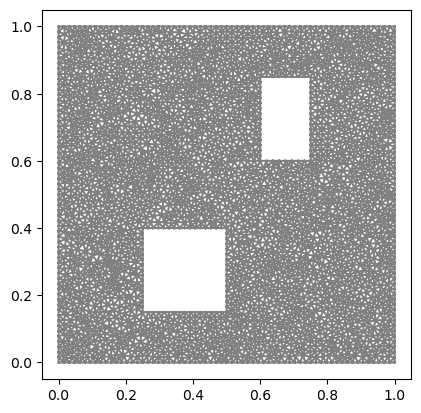

In [5]:
dl.plot(fom.mesh)

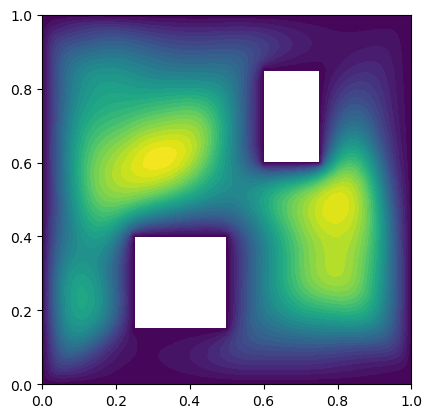

In [6]:
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)
fom.plot(state)

In [7]:
import fenics as dl
Du = dl.grad(state.state)
Du = dl.project(Du)
state.state([0.1, 0.05])


relative_errors = []

# for i in range(100):
x = np.array([0.1, 0.05])

h = 1e-8

fd_x = (state.state(x + np.array([h,0])) - state.state(x))/h
fd_y = (state.state(x + np.array([0,h])) - state.state(x))/h

print(fd_x, fd_y)
print(Du(x))
print(np.abs(fd_x - Du(x)[0])/max(np.abs(fd_x), 1e-4))


-0.055386285835457016 0.15660570756859116
[-0.05459918  0.15632595]
0.014211264450723847


In [8]:
prior_mean = np.zeros((n_para,))
# prior_mean[0] = 0.5
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

In [9]:
grid_t = np.linspace(0, 4, 401)
navigation = Navigation(grid_t = grid_t)
detector = Detector(fom, radius=0.1, sigma=0.025, resolution=100)
drone = Drone(detector=detector, navigation=navigation)

In [10]:
# user setting (for trying out different controls)
alpha = np.hstack(
            (np.linspace(0.5, 0.9, grid_t.shape[0]), np.linspace(0.1, 0.4, grid_t.shape[0]))
        )

# compute flight
flight = drone.plan_flight(alpha=alpha, grid_t=grid_t)  # Flight object
flightpath, grid_t_drone = flight.flightpath, flight.grid_t  # path and its time discretization

In [11]:
inversion = InverseProblem(fom, drone)

In [12]:
measurements = drone.measure(state=state, flight=flight)

In [13]:
x = np.linspace(0.001, 1, 101)-0.001
y = np.linspace(0.001, 1, 101)-0.001
# X, Y = np.meshgrid(x, y)
Z = np.zeros((len(x), len(y)))
Dx = np.zeros((len(x), len(y)))
Dy = np.zeros((len(x), len(y)))
FDx = np.zeros((len(x), len(y)))
FDy = np.zeros((len(x), len(y)))

Du = dl.grad(state.state)
Du = dl.project(Du, fom.gradient_space)
# Du = dl.project(Du)

h = 1e-8

for i in range(len(x)):
    for j in range(len(y)):
        try:
            Z[i,j] = state.state(x[i],y[j])
            Dx[i,j] = Du(x[i], y[j])[0]
            Dy[i,j] = Du(x[i], y[j])[1]
            
            FDx[i,j] = 1/h*(state.state(x[i] + h, y[j]) - state.state(x[i], y[j]))
            FDy[i,j] = 1/h*(state.state(x[i], y[j] + h) - state.state(x[i], y[j]))
        except:
            pass

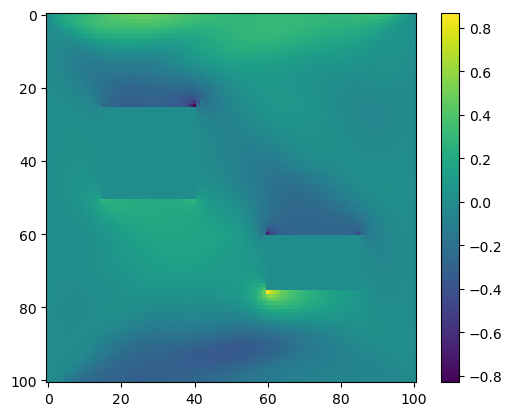

In [14]:
plt.imshow(Dx)
plt.colorbar()

In [15]:
A = np.zeros((len(x), len(y)))

Bx = np.zeros((len(x), len(y)))
By = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        print
        A[i,j] = state.convolution[eval_mode](np.array([[x[i], y[j]]]))[0]
        B = state.convolution[eval_mode].grad(np.array([[x[i], y[j]]]))
        Bx[i,j] = B[0,0]
        By[i,j] = B[0,1]


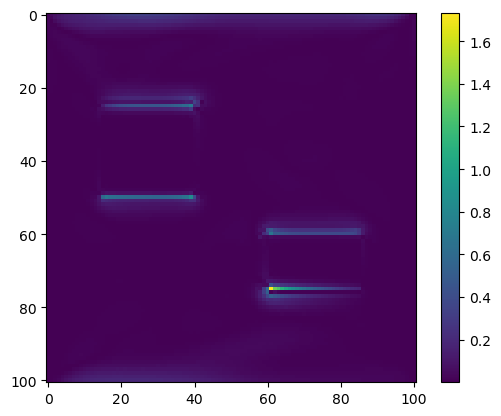

In [16]:
plt.imshow(np.abs(FDx-Bx))
plt.colorbar()

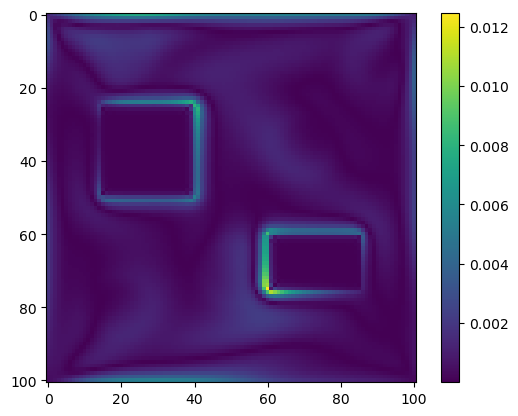

In [17]:
plt.imshow(np.abs(Z - A))
plt.colorbar()

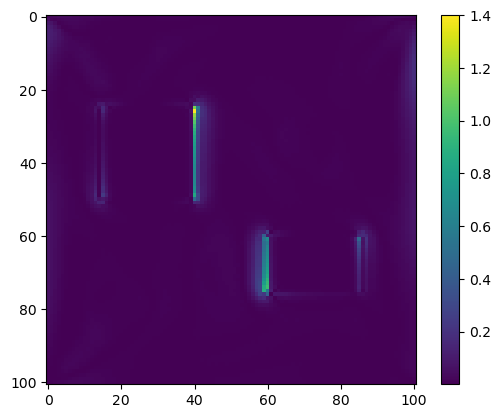

In [18]:
plt.imshow(np.abs(Dy - By))
plt.colorbar()

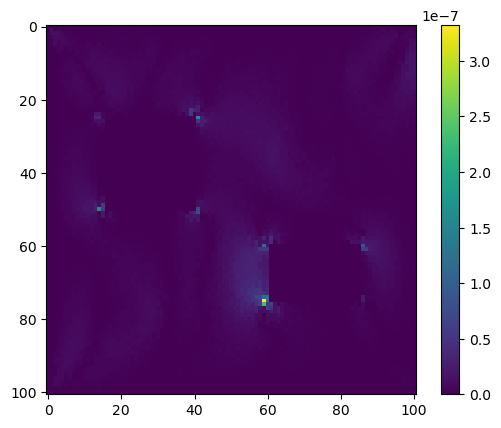

In [19]:
plt.imshow(np.abs(FDy - Dy))
plt.colorbar()

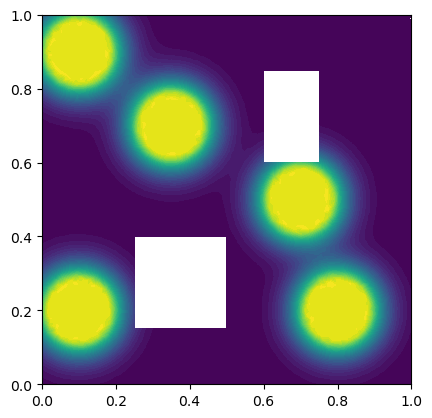

In [20]:
fom.plot(fom.assemble_forcing(para_true))

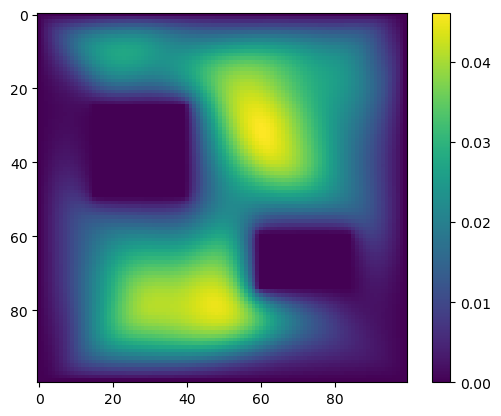

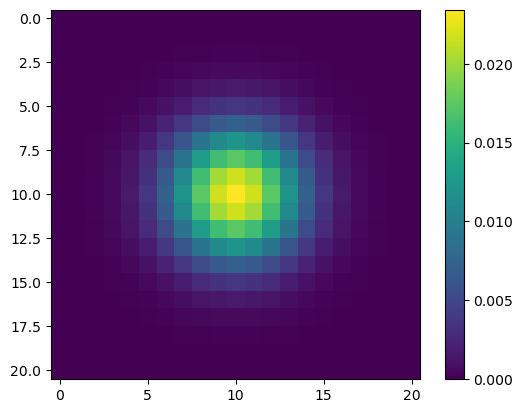

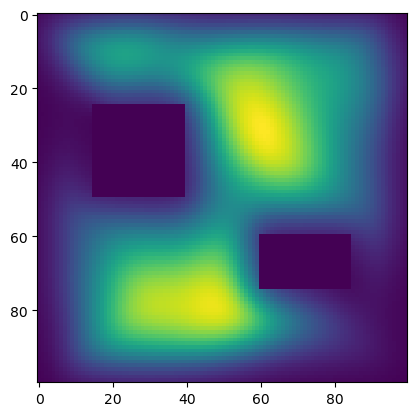

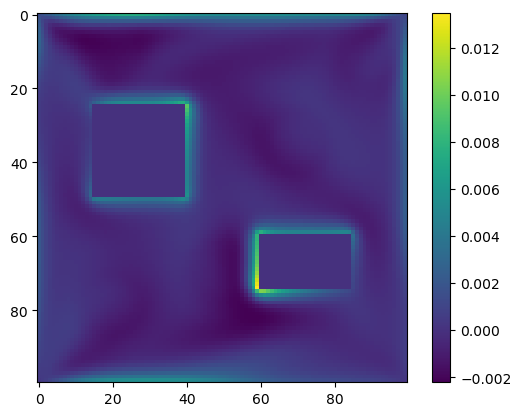

In [21]:
from scipy.ndimage import convolve
# drone.detector.convolution(np.array([[0.5, 0.5]]))

x= np.linspace(0,1)
y= np.linspace(0,1)

X, Y = np.meshgrid(x, y)

plt.figure()
# plt.imshow(drone.detector.convolution.interp_Z((X, Y)))
plt.imshow(state.convolution[eval_mode].sampled_state)
plt.colorbar()
plt.figure()
# plt.imshow(drone.detector.convolution.interp_Z((X, Y)))
plt.imshow(state.convolution[eval_mode].kernel)
plt.colorbar()
plt.figure()
plt.imshow(state.convolution[eval_mode].convolved_state)
# plt.imshow(convolve(drone.detector.convolution.sampled_state, drone.detector.convolution.kernel, mode="constant")/ drone.detector.convolution.weight)
# plt.imshow(convolve(drone.detector.convolution.sampled_state, drone.detector.convolution.kernel, mode="constant"))
# plt.imshow(drone.detector.convolution.sampled_state/ drone.detector.convolution.weight)

plt.figure()
plt.imshow(state.convolution[eval_mode].convolved_state - state.convolution[eval_mode].sampled_state)
plt.colorbar()

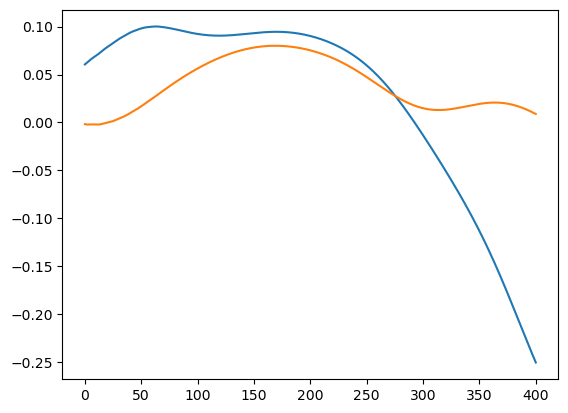

In [22]:
plt.plot(state.convolution[eval_mode].grad(flight.flightpath))

In [23]:
posterior = inversion.compute_posterior(flight=flight)

In [24]:
posterior.compute_mean(data=measurements)

array([4.57500414e-03, 8.20072976e-01, 2.64423916e-01, 1.83721604e-03,
       1.25314275e-04])

In [25]:
utility = OEDUtility(inversion)

In [26]:
# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.hstack(
            (np.linspace(0.5, 0.9, grid_t.shape[0]), np.linspace(0.1, 0.4, grid_t.shape[0]))
        )
posterior_ref = inversion.compute_posterior(alpha=alpha_test, grid_t = grid_t)

util_ref = np.zeros(4)
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

der_ref_A = utility.d_utility_d_position(posterior_ref, mode="A")
der_ref_D = utility.d_utility_d_position(posterior_ref, mode="D")
der_ref_Dinv = utility.d_utility_d_position(posterior_ref, mode="D-inverse")

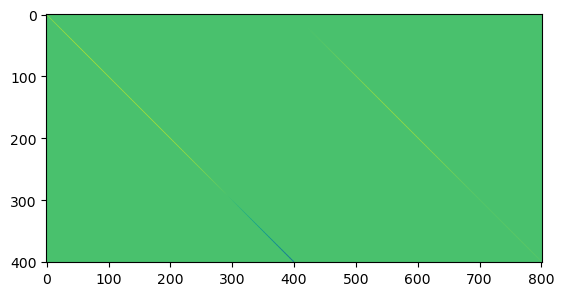

In [27]:
plt.figure()
plt.imshow(drone.detector.d_measurement_d_position(flight, state))

In [28]:
der = utility.d_utilA_d_position(inversion.compute_posterior(alpha=alpha_test, grid_t=grid_t)).reshape((2, grid_t_drone.shape[0])).transpose()
der

array([[ 2.73249982e-04, -7.01251822e-06],
       [-6.26480731e-04,  1.83438827e-05],
       [-6.42029508e-04,  1.98895401e-05],
       [-6.58467790e-04,  2.01808996e-05],
       [-6.75725677e-04,  1.98073930e-05],
       [-6.93251029e-04,  1.93299673e-05],
       [-7.10319922e-04,  1.91414693e-05],
       [-7.26942463e-04,  1.93618199e-05],
       [-7.43225314e-04,  1.99304515e-05],
       [-7.59324172e-04,  2.06711021e-05],
       [-7.75465277e-04,  2.13337023e-05],
       [-7.91913762e-04,  2.16383794e-05],
       [-8.08940043e-04,  2.13218401e-05],
       [-8.26784898e-04,  2.01849597e-05],
       [-8.45623002e-04,  1.81409179e-05],
       [-8.65510970e-04,  1.52625940e-05],
       [-8.86125110e-04,  1.18318837e-05],
       [-9.06868113e-04,  8.27681614e-06],
       [-9.27414189e-04,  4.84470558e-06],
       [-9.47638169e-04,  1.60302993e-06],
       [-9.67560439e-04, -1.52308708e-06],
       [-9.87318693e-04, -4.70956036e-06],
       [-1.00713564e-03, -8.18813888e-06],
       [-1.

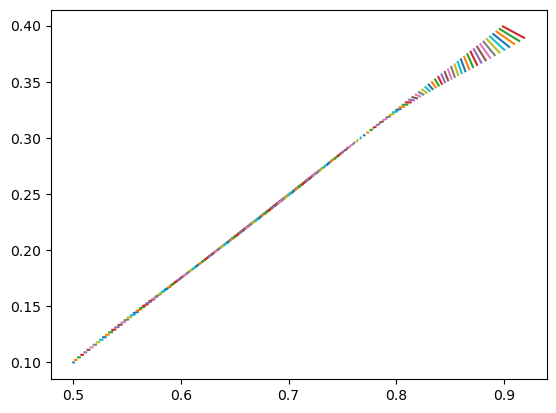

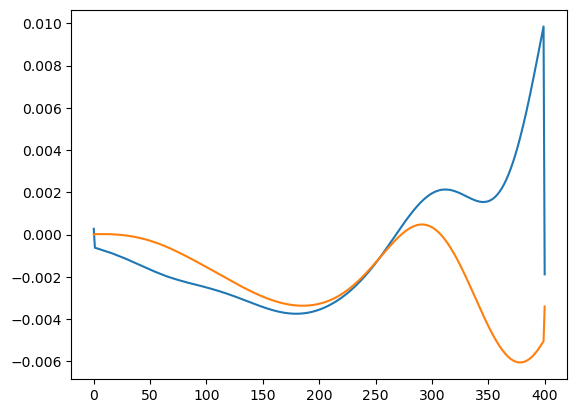

In [29]:
for i in range(flightpath.shape[0]):
    # plt.plot([flightpath[i,0], flightpath[i,0] + der[i,0]/np.sqrt(der[i,0]**2 + der[i,1]**2)/30],
    #          [flightpath[i,1], flightpath[i,1] + der[i,1]/np.sqrt(der[i,0]**2 + der[i,1]**2)/30])
    if i%3 == 0:
        plt.plot([flightpath[i,0], flightpath[i,0] + der[i,0]*2],
                 [flightpath[i,1], flightpath[i,1] + der[i,1]*2])
plt.figure()
plt.plot(der)

(0.0, 1.0)

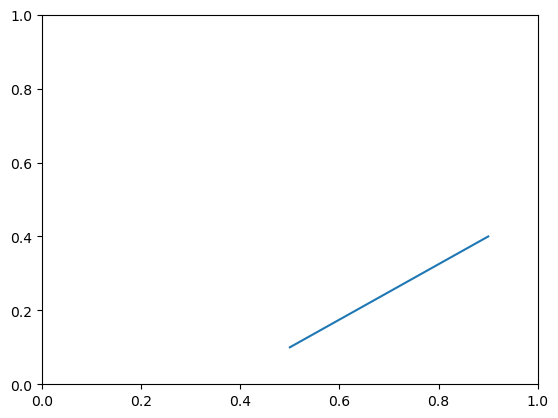

In [30]:
plt.plot(flightpath[:,0], flightpath[:,1])
plt.xlim([0,1])
plt.ylim([0,1])

In [70]:
import numpy as np

def arc_length_interpolation(vertices, n_points):
    # Calculate arc length between each pair of vertices
    distances = np.sqrt(np.sum(np.diff(vertices, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    total_length = cumulative_distances[-1]
    
    # Generate evenly spaced points along the arc length
    even_spaced_points = np.linspace(0, total_length, n_points)
    
    # Interpolate points
    interp_points = np.zeros((n_points, vertices.shape[1]))
    for i in range(vertices.shape[1]):
        interp_points[:, i] = np.interp(even_spaced_points, cumulative_distances, vertices[:, i])
    
    return interp_points

# Example usage
vertices = np.array([[0, 0], [1, 2], [2, 0], [0,1]])
n_points = 100
points = arc_length_interpolation(vertices, n_points)


In [143]:
from Optimization.DAE import Objective as objective_class

vertices = np.array([[0.7, 0.3], [0.5, 0.5], [0.2, 0.5], [0.1,0.1]])


problem_obj = objective_class(grid_t_drone, utility, inversion, 
                              piecewise_constant=None,
                              use_exact_DAE = True,
                              circle_mode = False,
                              enforce_initial_position = False,
                              enforce_final_position = False,
                              reg_strength = 1e-5,
                              OED_utility_mode = "A",
                              # OED_mix = {"A": 1.0, "D": 10.0, "E": 1.0},
                              # v_lower = 0.1,
                              # v_upper = 3,
                              # acc_lower = -100,
                              # acc_upper = 100,
                              # omega_upper = 100,
                              # omega_lower = -100,
                              # omega_acc_upper = 10000,
                              # omega_acc_lower = -10000,
                              build_video = True,
                              x0 = vertices[0,0],
                              y0 = vertices[0,1],
                              x_final = vertices[-1,0],
                              y_final = vertices[-1,1],
                              # x0 = 0.1,
                              # y0 = 0.1,
                              # x_final = 0.7,
                              # y_final = 0.3,
                             )

In [144]:
# Set the initial guess for the decision variables
points = arc_length_interpolation(vertices, problem_obj.NK)

initial_x = points[:,0]
initial_y = points[:,1]

initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = np.ones(initial_x.shape)
initial_acc = np.ones(initial_x.shape)
initial_omega = np.ones(initial_x.shape)
initial_omega_acc = np.ones(initial_x.shape)

x0 = problem_obj.var_joiner(initial_x, initial_y, initial_theta, initial_v, initial_acc, initial_omega, initial_omega_acc)

In [131]:
initial_x = 0.75/2 + 0.25 * np.cos(grid_t_drone)
initial_y = 0.55/2 + 0.25 * np.sin(grid_t_drone)

# initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_theta = grid_t_drone + np.pi/2
initial_v = 0.25*np.ones(initial_x.shape)
initial_acc = np.zeros(initial_x.shape)
initial_omega = np.ones(initial_x.shape)
initial_omega_acc = np.zeros(initial_x.shape)

In [132]:
x0 = problem_obj.var_joiner(initial_x, initial_y, initial_theta, initial_v, initial_acc, initial_omega, initial_omega_acc)

In [145]:
problem_obj.objective(x0)

4.111129510590652

In [146]:
# x0 = solution

problem_obj.add_option("hessian_approximation", "limited-memory")
problem_obj.add_option("tol", 1e-3)
# problem_obj.add_option("max_iter", 3)
# problem_obj.add_option("derivative_test_print_all", "yes")
# problem_obj.add_option("derivative_test", "first-order")
# problem_obj.add_option("gradient_approximation", "finite-difference-values")
# Solve the problem
solution, info = problem_obj.solve(x0)
# solution, info = problem.solve(solution)

# Print the solution
# print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")
print(f"OED objective value: {problem_obj.OED_objective(solution)}")
# output the value of the trajectory whenever the gradient is evaluated to make a video
# (objective value; constraint violation)

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     7600
Number of nonzeros in inequality constraint Jacobian.:     1604
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2807
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2406
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2000
Total number of inequality constraints...............:      802
        inequality constraints with only lower bounds:      802
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1111295e+00 5.29e+00 1.35e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [147]:
print(f"OED objective value: {problem_obj.OED_objective(solution)}")

OED objective value: 3.474348747460869


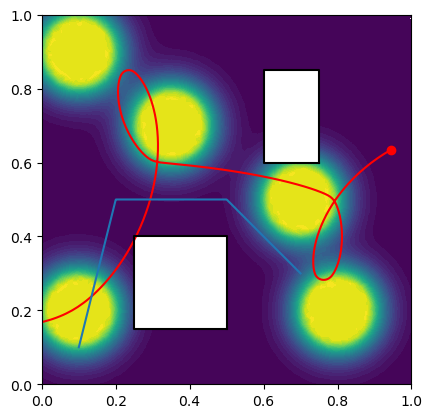

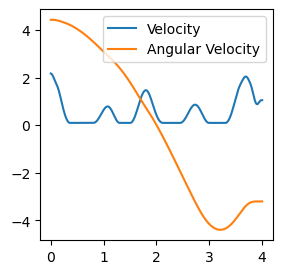

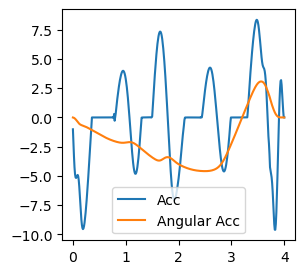

In [148]:
(x, y, theta, v, acc, omega, omega_acc) = problem_obj.var_splitter(solution)

(prev_x, prev_y, prev_theta, prev_v, prev_acc, prev_omega, prev_omega_acc) = problem_obj.var_splitter(solution)
prev_grid_t = grid_t_drone

plt.figure()
# fom.plot(state)
fom.plot(fom.assemble_forcing(para_true))
plt.plot(x, y, label="Optimized path", color="red")
# plt.scatter(x, y, marker='d')
plt.scatter(x[0], y[0], marker='o', color="red")
# plt.scatter(problem_obj.x0, problem_obj.y0, marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])


(initial_x, initial_y, _, _, _, _, _) = problem_obj.var_splitter(x0)
plt.plot(initial_x, initial_y, label="Initial path")

obstacle_shape = problem_obj.obstacle_shape

# if obstacle_shape == "circle":
#     style = 'k'
# else:
#     style = 'k--'
# # circle
# t = np.linspace(0, 2*np.pi, 100)
# for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
#     plt.plot(rx*np.cos(t) + cx, ry*np.sin(t) + cy, style)

# if obstacle_shape == "diamond":
#     style = 'k'
# else:
#     style = 'k--'
# # diamond
# for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
#     plt.plot([cx, cx + rx, cx, cx - rx, cx], [cy + ry, cy, cy - ry, cy, cy + ry], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

# plt.legend()

plt.figure(figsize=(3,3))
plt.plot(grid_t_drone, v, label="Velocity")
plt.plot(grid_t_drone, omega, label="Angular Velocity")
plt.legend()

plt.figure(figsize=(3,3))
plt.plot(grid_t_drone, acc, label="Acc")
plt.plot(grid_t_drone, omega_acc, label="Angular Acc")
plt.legend()

In [149]:
import matplotlib.pyplot as plt
import os
from moviepy.editor import ImageSequenceClip
from tqdm import tqdm

# Define a function to create your plots (replace this with your actual plotting code)
def generate_plot(vars):
    (x, y, theta, v, acc, omega, omega_acc) = problem_obj.var_splitter(vars)

    # fom.plot(fom.assemble_forcing(para_true))
    
    (initial_x, initial_y, _, _, _, _, _) = problem_obj.var_splitter(x0)
    plt.plot(initial_x, initial_y, label="Initial path")
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    plt.plot(x, y, label="Optimized path", color="red")
    plt.scatter(x[0], y[0], marker='o', color="red")
    
    obstacle_shape = problem_obj.obstacle_shape
    
    if obstacle_shape == "square":
        style = 'k'
    else:
        style = 'k--'
    # square
    for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
        plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], style)


for filename in os.listdir("frames"):
    file_path = os.path.join("frames", filename)
    try:
        if os.path.isfile(file_path):  # Check if it's a file
            os.remove(file_path)
    except OSError as e:
        print(f"Error removing file: {filename} ({e})")

# Create a directory to store the frames (optional)
os.makedirs("frames", exist_ok=True)  # Create directory if it doesn't exist

# fig = plt.figure()

objective_values = [frame["obj_value"] for i, frame in problem_obj.video_frames.items()]
inf_dus = [frame["inf_du"] for i, frame in problem_obj.video_frames.items()]

# Generate frames and save them as PNGs
for i, frame in tqdm(problem_obj.video_frames.items()):
    # # Create a figure (assuming fom.plot creates its own figure)
    # fig, _ = plt.subplots()  # Create a dummy subplot (not used)
    
    # # Call fom.plot to generate your FEM solution plot on the figure
    # fom.plot(state)  # This might create a new figure by default
    
    # Now create subplots within the existing figure
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    plt.sca(ax2)
    plt.title("OED-A + Regularization Objective")
    plt.xlabel("IPOPT Iteration")
    plt.plot(objective_values)
    plt.scatter([i], [frame["obj_value"]])

    plt.sca(ax3)
    plt.title("Dual infeasibility")
    plt.xlabel("IPOPT Iteration")
    plt.plot(inf_dus)
    plt.scatter([i], [frame["inf_du"]])
    plt.yscale('log')
    # plt.axis('square')
    
    plt.sca(ax1)
    plt.title("Observation path")
    plt.xlim([-0,1])
    plt.ylim([-0,1])
    plt.axis('square')
    fom.plot(state)
    generate_plot(frame["iterate"]["x"])

    plt.savefig(f"frames/frame_{i + 1:04d}.png")
    # plt.show()
    plt.clf()  # Clear the figure to avoid overlapping plots

# Use moviepy to combine the frames into a video (replace 'my_video.mp4' with your desired filename)
# clip = ImageSequenceClip("frames/*.png", fps=10)  # Adjust frame rate (fps) as needed
# clip = ImageSequenceClip(os.path.join("frames", "*.png"), fps=10)
# clip = ImageSequenceClip(os.path.abspath("frames/*.png"), fps=10)
clip = ImageSequenceClip(os.path.abspath("frames"), fps=10)
clip.write_videofile("my_video.mp4")

print("Video frames generated and saved as my_video.mp4")
        

# plt.figure(figsize=(3,3))
# plt.plot(grid_t_drone, v, label="Velocity")
# plt.plot(grid_t_drone, omega, label="Angular Velocity")
# plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1595/1595 [14:51<00:00,  1.79it/s]


Moviepy - Building video my_video.mp4.
Moviepy - Writing video my_video.mp4



Moviepy - Done !
Moviepy - video ready my_video.mp4
Video frames generated and saved as my_video.mp4


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [57]:
import pickle as pkl
with open('video_test.pkl', 'wb') as f:
    pkl.dump(problem_obj.video_frames, f)

TypeError: object of type 'Axes' has no len()

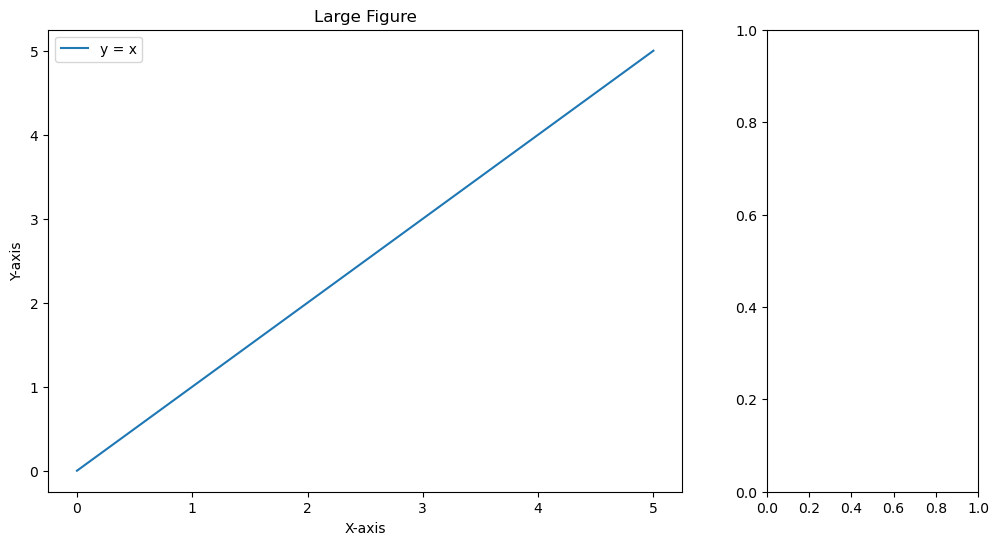

In [52]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Define figure size
fig_width = 12
fig_height = 6

# Create the figure and subplots with GridSpec
fig, (ax_large, axs_small) = plt.subplots(1, 2, figsize=(fig_width, fig_height), gridspec_kw={'width_ratios': [3, 1]})

# Generate some example data for the large figure (ax_large)
x_large = np.linspace(0, 5, 100)
y_large = x_large

# Plot data on the large figure
ax_large.plot(x_large, y_large, label='y = x')
ax_large.set_xlabel('X-axis')
ax_large.set_ylabel('Y-axis')
ax_large.set_title('Large Figure')
ax_large.legend()

# Plot data on the small figures
# Loop through each subplot using its index
for i in range(len(axs_small)):  # Corrected loop
  ax = axs_small[i]
  # Generate data for each subplot (x range adjusted for better visualization)
  x_small = np.linspace(-1, 2, 50)  # Adjust x range for each subplot
  y_small = x_small

  # Plot y = x for each subplot
  ax.plot(x_small, y_small, label='y = x')

  # Set labels and title for each subplot (modify as needed)
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_title('Subplot ' + str(ax.get_subplotspec().colindex + 1))  # Title based on subplot column index
  ax.legend()

# Adjust layout (optional)
fig.suptitle('Your Figure Title')
plt.tight_layout()

# Display the plot
plt.show()


# Debugging

In [ ]:
from scipy.sparse import coo_array
from functools import cached_property

class Objective:
    def __init__(self):
        self.x0 = 0.8
        self.y0 = 0.8
        self.theta0 = 0.0
        self.x_final = 0.0
        self.y_final = 0.0
        self.theta_final = np.pi
        
        # # Obstacles
        # self.cxs = [0.5, 0.4, -0.01]
        # self.cys = [0.5, 0.0, 0.1]
        # self.rxs = [0.35, 0.15, 0.09]
        # self.rys = [0.25, 0.15, 0.09]
        # self.obstacle_shape = "circle"
        # Obstacles
        self.cxs = []
        self.cys = []
        self.rxs = []
        self.rys = []
        self.obstacle_shape = "circle"
        
        # bounds
        self.x_lower = 0
        self.x_upper = 1
        self.y_lower = 0
        self.y_upper = 1
        self.theta_lower = -1000
        self.theta_upper = 1000
        self.v_lower = 0.0
        self.v_upper = 1
        self.acc_lower = -10
        self.acc_upper = 10
        self.omega_lower = -100*np.pi
        self.omega_upper = 100*np.pi
        self.omega_acc_lower = -100
        self.omega_acc_upper = 100
        
        self.T = 4.0  # final time
        self.NK = 100  # number of time steps
        self.h = self.T/self.NK  # time grid spacing
        self.reg = 0.001  # regularization term

        self.x_shift = 0*self.NK
        self.y_shift = 1*self.NK
        self.theta_shift = 2*self.NK
        self.v_shift = 3*self.NK
        self.acc_shift = 4*self.NK
        self.omega_shift = 5*self.NK
        self.omega_acc_shift = 6*self.NK

        self.n = self.NK*7 # number of variables
        # self.num_equality_constraints = (self.NK - 1) * 5 + 4
        # self.m = self.num_equality_constraints + (self.NK) * len(self.cxs) # self.constraints(jnp.zeros((self.n, ))).shape[0] # number of constraints (also initializes the number of equality/inequality constraints)

        self.constraints(jnp.zeros((self.NK * 7,)))

    @property
    def m(self):
        return self.num_equality_constraints + self.num_inequality_constraints
        
    def var_joiner(self, x, y, theta, v, acc, omega, omega_acc):
        """Join variables into a single vector"""
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def var_splitter(self, vars):
        """Split variables from a single vector"""
        x = vars[self.x_shift:self.x_shift + self.NK]
        y = vars[self.y_shift:self.y_shift + self.NK]
        theta = vars[self.theta_shift:self.theta_shift + self.NK]
        v = vars[self.v_shift:self.v_shift + self.NK]
        acc = vars[self.acc_shift:self.acc_shift + self.NK]
        omega = vars[self.omega_shift:self.omega_shift + self.NK]
        omega_acc = vars[self.omega_acc_shift:self.omega_acc_shift + self.NK]
        return (x, y, theta, v, acc, omega, omega_acc)
        
    @property
    def lb(self):
        """Lower bounds on variables"""
        x = self.x_lower*jnp.ones((self.NK,))
        y = self.y_lower*jnp.ones((self.NK,))
        theta = self.theta_lower*jnp.ones((self.NK,))
        v = self.v_lower*jnp.ones((self.NK,))
        acc = self.acc_lower*jnp.ones((self.NK,))
        omega = self.omega_lower*jnp.ones((self.NK,))
        omega_acc = self.omega_acc_lower*jnp.ones((self.NK,))
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    @property
    def ub(self):
        """Upper bound on variables"""
        x = self.x_upper*jnp.ones((self.NK,))
        y = self.y_upper*jnp.ones((self.NK,))
        theta = self.theta_upper*jnp.ones((self.NK,))
        v = self.v_upper*jnp.ones((self.NK,))
        acc = self.acc_upper*jnp.ones((self.NK,))
        omega = self.omega_upper*jnp.ones((self.NK,))
        omega_acc = self.omega_acc_upper*jnp.ones((self.NK,))
        return jnp.concat((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def objective(self, vars):
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        return self.reg*(jnp.sum(v**2) + jnp.sum(omega**2))
        
    def gradient(self, vars):
        """Objective function gradient"""
        return jax.grad(self.objective)(vars)

    def circle_obstacle(self, x, y, cx, cy, rx, ry):
        """Circular obstacle"""
        return ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1

    def diamond_obstacle(self, x, y, cx, cy, rx, ry):
        """Diamond obstacle"""
        return jnp.abs((x - cx)/rx) + jnp.abs((y - cy)/ry) - 1

    def square_obstacle(self, x, y, cx, cy, rx, ry):
        """Square obstacle"""
        return jnp.abs(((x - cx)/rx + (y - cy)/ry)/2) + jnp.abs(((x - cx)/rx - (y - cy)/ry)/2) - 1

    # @jax.jit
    def constraints(self, vars):
        """Values to constrain between cl and cu"""
        # Equality constraints
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        # dae_x = (x[1:] - x[:-1]) - self.h * jnp.cos(theta[:-1]) * v[:-1] # == 0
        dae_x = jnp.diff(x) - self.h * jnp.cos(theta[:-1]) * v[:-1] # == 0
        # dae_y = (y[1:] - y[:-1]) - self.h * jnp.sin(theta[:-1]) * v[:-1] # == 0
        dae_y = jnp.diff(y) - self.h * jnp.sin(theta[:-1]) * v[:-1] # == 0
        # dae_theta = (theta[1:] - theta[:-1]) - self.h * omega[:-1] # == 0
        dae_theta = jnp.diff(theta) - self.h * omega[:-1] # == 0
        # dae_acc = (v[1:] - v[:-1]) - self.h * acc[:-1] # == 0
        dae_acc = jnp.diff(v) - self.h * acc[:-1] # == 0
        # dae_omega_acc = (omega[1:] - omega[:-1]) - self.h * omega_acc[:-1] # == 0
        dae_omega_acc = jnp.diff(omega) - self.h * omega_acc[:-1] # == 0
        initial_x = x[0] - self.x0 # == 0
        initial_y = y[0] - self.y0 # == 0
        final_x = x[-1] - self.x_final # == 0
        final_y = y[-1] - self.y_final # == 0
        cons = jnp.concat((dae_x, dae_y, dae_theta, dae_acc, dae_omega_acc, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        # cons = jnp.concat((dae_x, dae_y, dae_theta, dae_acc, dae_omega_acc,), axis = 0)
        # cons = jnp.array((initial_x, initial_y, final_x, final_y))
        # cons = jnp.concat((dae_x, dae_y, dae_theta, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        self.num_equality_constraints = len(cons)
        
        # Inequality contraints
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            cons = jnp.concat((cons, self.circle_obstacle(x, y, cx, cy, rx, ry))) # >= 0

        self.num_inequality_constraints = len(cons) - self.num_equality_constraints
        return cons

    @property
    def cl(self):
        """Constriant lower bounds"""
        return jnp.zeros((self.m,))

    @property
    def cu(self):
        """Constraint upper bounds"""
        upper_bound = np.zeros((self.m,))
        upper_bound[self.num_equality_constraints:] = np.inf
        return upper_bound

    # @jax.jit
    def jacobian(self, vars):
        """Jacobian of constraints"""
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        return jax.jacfwd(self.constraints)(vars)


In [ ]:
from scipy.sparse import coo_array
from functools import cached_property

class Objective:
    def __init__(self):
        self.x0 = 0.8
        self.y0 = 0.8
        self.theta0 = 0.0
        self.x_final = 0.0
        self.y_final = 0.0
        self.theta_final = np.pi
        
        # Obstacles
        self.cxs = [0.5, 0.4, -0.01]
        self.cys = [0.5, 0.0, 0.1]
        self.rxs = [0.35, 0.15, 0.09]
        self.rys = [0.15, 0.15, 0.09]
        self.obstacle_shape = "circle"
        # self.obstacle_shape = "diamond"
        # self.obstacle_shape = "square"
        # # Obstacles
        # self.cxs = []
        # self.cys = []
        # self.rxs = []
        # self.rys = []
        # self.obstacle_shape = "circle"
        
        # bounds
        self.x_lower = 0
        self.x_upper = 1
        self.y_lower = 0
        self.y_upper = 1
        self.theta_lower = -1000
        self.theta_upper = 1000
        self.v_lower = 0.0
        self.v_upper = 1
        self.acc_lower = -10
        self.acc_upper = 10
        self.omega_lower = -100*np.pi
        self.omega_upper = 100*np.pi
        self.omega_acc_lower = -100
        self.omega_acc_upper = 100
        
        self.T = 4.0  # final time
        self.NK = 50  # number of time steps
        self.h = self.T/self.NK  # time grid spacing
        self.reg = 0.001  # regularization term

        self.x_shift = 0*self.NK
        self.y_shift = 1*self.NK
        self.theta_shift = 2*self.NK
        self.v_shift = 3*self.NK
        self.acc_shift = 4*self.NK
        self.omega_shift = 5*self.NK
        self.omega_acc_shift = 6*self.NK

        self.n = self.NK*7 # number of variables
        # self.num_equality_constraints = (self.NK - 1) * 5 + 4
        # self.m = self.num_equality_constraints + (self.NK) * len(self.cxs) # self.constraints(jnp.zeros((self.n, ))).shape[0] # number of constraints (also initializes the number of equality/inequality constraints)

        self.constraints(np.zeros((self.n,)))

    @property
    def m(self):
        return self.num_equality_constraints + self.num_inequality_constraints

    def var_joiner(self, x, y, theta, v, acc, omega, omega_acc):
        """Join variables into a single vector"""
        return np.concatenate((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def var_splitter(self, vars):
        """Split variables from a single vector"""
        x = vars[self.x_shift:self.x_shift + self.NK]
        y = vars[self.y_shift:self.y_shift + self.NK]
        theta = vars[self.theta_shift:self.theta_shift + self.NK]
        v = vars[self.v_shift:self.v_shift + self.NK]
        acc = vars[self.acc_shift:self.acc_shift + self.NK]
        omega = vars[self.omega_shift:self.omega_shift + self.NK]
        omega_acc = vars[self.omega_acc_shift:self.omega_acc_shift + self.NK]
        # y = vars[self.NK:2*self.NK]
        # theta = vars[2*self.NK:3*self.NK]
        # v = vars[3*self.NK:4*self.NK]
        # acc = vars[4*self.NK:5*self.NK]
        # omega = vars[5*self.NK:6*self.NK]
        # omega_acc = vars[6*self.NK:7*self.NK]
        return (x, y, theta, v, acc, omega, omega_acc)
        
    @property
    def lb(self):
        """Lower bounds on variables"""
        x = self.x_lower*np.ones((self.NK,))
        y = self.y_lower*np.ones((self.NK,))
        theta = self.theta_lower*np.ones((self.NK,))
        v = self.v_lower*np.ones((self.NK,))
        acc = self.acc_lower*np.ones((self.NK,))
        omega = self.omega_lower*np.ones((self.NK,))
        omega_acc = self.omega_acc_lower*np.ones((self.NK,))
        return np.concatenate((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    @property
    def ub(self):
        """Upper bound on variables"""
        x = self.x_upper*np.ones((self.NK,))
        y = self.y_upper*np.ones((self.NK,))
        theta = self.theta_upper*np.ones((self.NK,))
        v = self.v_upper*np.ones((self.NK,))
        acc = self.acc_upper*np.ones((self.NK,))
        omega = self.omega_upper*np.ones((self.NK,))
        omega_acc = self.omega_acc_upper*np.ones((self.NK,))
        return np.concatenate((x, y, theta, v, acc, omega, omega_acc), axis=0)
        
    def objective(self, vars):
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        return self.reg*np.sum(v**2) + self.reg*np.sum(omega**2)
        
    def gradient(self, vars):
        """Objective function gradient"""
        (_, _, _, v, _, omega, _) = self.var_splitter(vars)

        x = np.zeros(v.shape)
        y = np.zeros(v.shape)
        theta = np.zeros(v.shape)
        v = self.reg*2*v
        acc = np.zeros(v.shape)
        omega = self.reg*2*omega
        omega_acc = np.zeros(v.shape)
        
        return self.var_joiner(x, y, theta, v, acc, omega, omega_acc)

    def circle_obstacle(self, x, y, cx, cy, rx, ry):
        """Circular obstacle"""
        return ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1

    def diamond_obstacle(self, x, y, cx, cy, rx, ry):
        """Diamond obstacle"""
        return np.abs((x - cx)/rx) + np.abs((y - cy)/ry) - 1

    def square_obstacle(self, x, y, cx, cy, rx, ry):
        """Square obstacle"""
        return np.abs(((x - cx)/rx + (y - cy)/ry)/2) + np.abs(((x - cx)/rx - (y - cy)/ry)/2) - 1

    # @jax.jit
    def constraints(self, vars):
        """Values to constrain between cl and cu"""
        # Equality constraints
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        dae_x = (x[1:] - x[:-1]) - self.h * np.cos(theta[:-1]) * v[:-1] # == 0
        dae_y = (y[1:] - y[:-1]) - self.h * np.sin(theta[:-1]) * v[:-1] # == 0
        dae_theta = (theta[1:] - theta[:-1]) - self.h * omega[:-1] # == 0
        dae_acc = (v[1:] - v[:-1]) - self.h * acc[:-1] # == 0
        dae_omega_acc = (omega[1:] - omega[:-1]) - self.h * omega_acc[:-1] # == 0
        initial_x = x[0] - self.x0 # == 0
        initial_y = y[0] - self.y0 # == 0
        final_x = x[-1] - self.x_final # == 0
        final_y = y[-1] - self.y_final # == 0
        cons = np.concatenate((dae_x, dae_y, dae_theta, dae_acc, dae_omega_acc, np.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        # cons = jnp.array((initial_x, initial_y, final_x, final_y))
        # cons = jnp.concat((dae_x, dae_y, dae_theta, jnp.array((initial_x, initial_y, final_x, final_y))), axis = 0)
        self.num_equality_constraints = len(cons)
        
        # Inequality contraints
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            if self.obstacle_shape == "circle":
                cons = np.concatenate((cons, self.circle_obstacle(x, y, cx, cy, rx, ry)), axis = 0) # >= 0
            elif self.obstacle_shape == "square":
                cons = np.concatenate((cons, self.square_obstacle(x, y, cx, cy, rx, ry)), axis = 0) # >= 0
            elif self.obstacle_shape == "diamond":
                cons = np.concatenate((cons, self.diamond_obstacle(x, y, cx, cy, rx, ry)), axis = 0) # >= 0

        self.num_inequality_constraints = len(cons) - self.num_equality_constraints
        return cons

    @property
    def cl(self):
        """Constriant lower bounds"""
        return np.zeros((self.m,))

    @property
    def cu(self):
        """Constraint upper bounds"""
        upper_bound = np.zeros((self.m,))
        upper_bound[self.num_equality_constraints:] = np.inf
        return upper_bound

    
    def jacobianstructure(self):
        return self.memoized_jac_structure
    
    @cached_property
    def memoized_jac_structure(self) -> tuple[np.ndarray,np.ndarray]:
        # (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        # return jax.experimental.sparse.jacfwd(self.contraints)(x)
        # return jax.jacfwd(self.constraints)(vars)
        rows = []
        columns = []
        # values = []
        row = 0
        for i in range(self.NK - 1):
            columns += [i + 1 + self.x_shift, i + self.x_shift, i + self.theta_shift, i + self.v_shift]
            rows += [row]*4
            # values += [1, -1, self.h * jnp.sin(theta[i]) * v[i], -self.h * jnp.cos(theta[i])]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.y_shift, i + self.y_shift, i + self.theta_shift, i + self.v_shift]
            rows += [row]*4
            # values += [1, -1, -self.h * jnp.cos(theta[i]) * v[i], -self.h * jnp.sin(theta[i])]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.theta_shift, i + self.theta_shift, i + self.omega_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.v_shift, i + self.v_shift, i + self.acc_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        for i in range(self.NK - 1):
            columns += [i + 1 + self.omega_shift, i + self.omega_shift, i + self.omega_acc_shift]
            rows += [row]*3
            # values += [1, -1, -self.h]
            row += 1
        # Initial x
        columns += [0 + self.x_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Initial y
        columns += [0 + self.y_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Final x
        columns += [self.NK - 1 + self.x_shift]
        rows += [row]
        # values += [1]
        row += 1
        # Final y
        columns += [self.NK - 1 + self.y_shift]
        rows += [row]
        # values += [1]
        row += 1
        # ((x - cx)/rx)**2 + ((y - cy)/ry)**2 - 1
        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                columns += [i + self.x_shift, i + self.y_shift]
                rows += [row, row]
                # values += [2/rx*(x[i]-cx)/rx, 2/ry*(y[i]-cy)/ry]
                row += 1
        return (np.array(rows, dtype=int), np.array(columns, dtype=int))

    def jacobian(self, vars):
        """Jacobian of constraints"""
        (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
        rows, columns = self.jacobianstructure()
        values = np.zeros(rows.shape)
        index = 0
        for i in range(self.NK - 1):
            values[index:index + 4] = [1, -1, self.h * np.sin(theta[i]) * v[i], -self.h * np.cos(theta[i])]
            index += 4
        for i in range(self.NK - 1):
            values[index:index + 4] = [1, -1, -self.h * np.cos(theta[i]) * v[i], -self.h * np.sin(theta[i])]
            index += 4
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        for i in range(self.NK - 1):
            values[index:index + 3] = [1, -1, -self.h]
            index += 3
        # Initial x
        values[index] = 1
        index += 1
        # Initial y
        values[index] = 1
        index += 1
        # Final x
        values[index] = 1
        index += 1
        # Final y
        values[index] = 1
        index += 1

        for (cx, cy, rx, ry) in zip(self.cxs, self.cys, self.rxs, self.rys):
            for i in range(self.NK):
                if self.obstacle_shape == "circle":
                    values[index:index + 2] = [2*(x[i]-cx)/(rx**2), 2*(y[i]-cy)/(ry**2)]
                elif self.obstacle_shape == "square":
                    values[index:index + 2] = [np.sign((x[i]-cx)/rx + (y[i] - cy)/ry)/rx/2 + np.sign((x[i]-cx)/rx - (y[i] - cy)/ry)/rx/2,
                                               np.sign((x[i]-cx)/rx + (y[i] - cy)/ry)/ry/2 - np.sign((x[i]-cx)/rx - (y[i] - cy)/ry)/ry/2]
                elif self.obstacle_shape == "diamond":
                    values[index:index + 2] = [np.sign(x[i]-cx)/rx, np.sign(y[i]-cy)/ry]
                index += 2
        return values

    # def hessianstructure(self):
    #     return self.memoizedhessianstructure

    # @cached_property
    # def memoizedhessianstructure(self):
    #     hess = {}
    #     for i in range(self.NK):
    #         hess[(i + self.v_shift, i + self.v_shift)] = 1
    #         hess[(i + self.omega_shift, i + self.omega_shift)] = 1
    #         # Diagonal with 2*self.reg in v and omega regions, 0 elsewhere

    #     for i in range(self.NK - 1):
    #         hess[(i + self.theta_shift, i + self.theta_shift)] = 1
    #         hess[(i + self.v_shift, i + self.theta_shift)] = 1
    #     for j, (cx, cy, rx, ry) in enumerate(zip(self.cxs, self.cys, self.rxs, self.rys)):
    #         for i in range(self.NK):
    #             hess[(i + self.x_shift, i + self.x_shift)] = hess.get((i + self.x_shift, i + self.x_shift), 0) + 1
    #             hess[(i + self.y_shift, i + self.y_shift)] = hess.get((i + self.y_shift, i + self.y_shift), 0) + 1
    #     rows = [index[0] for index in hess.keys()]
    #     columns = [index[1] for index in hess.keys()]
    #     return (np.array(rows, dtype=int), np.array(columns, dtype=int))
        
    # def hessian(self, vars, lagrange, objective_factor):
    #     """
    #     Returns the non-zero values of the lagrangian Hessian.

    #     Lower diagonal entries only; matrix vector products;
    #     Arguments are:
    #         vars : variables
    #         lagrange : lagrange multipliers
    #         objective_factor : some representation of the objective
    #     """
    #     (x, y, theta, v, acc, omega, omega_acc) = self.var_splitter(vars)
    #     hess = {}
    #     for i in range(self.NK):
    #         hess[(i + self.v_shift, i + self.v_shift)] = 2 * self.reg * objective_factor #[i + self.v_shift]
    #         hess[(i + self.omega_shift, i + self.omega_shift)] = 2 * self.reg * objective_factor #[i + self.omega_shift]
    #         # Diagonal with 2*self.reg in v and omega regions, 0 elsewhere

    #     for i in range(self.NK - 1):
    #         hess[(i + self.theta_shift, i + self.theta_shift)] = self.h * jnp.cos(theta[i]) * v[i] * lagrange[i] + self.h * jnp.sin(theta[i]) * v[i] * lagrange[i + 1*(self.NK - 1)]
    #         hess[(i + self.theta_shift, i + self.v_shift)] = self.h * jnp.sin(theta[i]) * lagrange[i] - self.h * jnp.cos(theta[i]) * lagrange[i + 1*(self.NK - 1)]
    #     for j, (cx, cy, rx, ry) in enumerate(zip(self.cxs, self.cys, self.rxs, self.rys)):
    #         for i in range(self.NK):
    #             hess[(i + self.x_shift, i + self.x_shift)] = hess.get((i + self.x_shift, i + self.x_shift), 0.0) + 2/(rx**2) * lagrange[i + 4 + 5*(self.NK - 1) + j*self.NK]
    #             hess[(i + self.y_shift, i + self.y_shift)] = hess.get((i + self.y_shift, i + self.y_shift), 0.0) + 2/(ry**2) * lagrange[i + 4 + 5*(self.NK - 1) + j*self.NK]
    #     return np.array(list(hess.values()))
    #     # obj_hess = jax.jacrev(jax.jacfwd(self.objective)))
    #     # return jax.hessian(self.objective)(vars) * v[0]


In [ ]:
problem_obj = Objective()

problem = cyipopt.Problem(
    n = problem_obj.n,  # Number of decision variables
    m = problem_obj.m,  # Number of constraints
    problem_obj = problem_obj,  # Objective object with "objective" and "gradient" functions
    lb = problem_obj.lb,  # Lower bounds for x
    ub = problem_obj.ub,  # Upper bounds for x
    cl = problem_obj.cl,  # Lower bound for constraints
    cu = problem_obj.cu,  # Lower bound for constraints
)

In [ ]:
# # Set the initial guess for the decision variables
# initial_x = jnp.linspace(problem_obj.x0, 0.0, problem_obj.NK)
# initial_y = jnp.linspace(problem_obj.y0, 0.0, problem_obj.NK)
# initial_theta = jnp.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
# initial_v = jnp.ones(initial_x.shape)
# initial_acc = jnp.ones(initial_x.shape)
# initial_omega = jnp.ones(initial_x.shape)
# initial_omega_acc = jnp.ones(initial_x.shape)

# Set the initial guess for the decision variables
initial_x = np.linspace(problem_obj.x0, 0.0, problem_obj.NK)
initial_y = np.linspace(problem_obj.y0, 0.0, problem_obj.NK)
initial_theta = np.arctan2(np.diff(initial_y, append=0.),np.diff(initial_x, append=0.))
initial_v = np.ones(initial_x.shape)
initial_acc = np.ones(initial_x.shape)
initial_omega = np.ones(initial_x.shape)
initial_omega_acc = np.ones(initial_x.shape)

x0 = problem_obj.var_joiner(initial_x, initial_y, initial_theta, initial_v, initial_acc, initial_omega, initial_omega_acc)

In [ ]:
# plt.figure()
# plt.imshow(jnp.log(jnp.abs(problem_obj.jacobian(x0))))
# plt.imshow(jnp.abs(problem_obj.jacobian(x0))>0)
jac_v = problem_obj.jacobian(x0)
r, c = problem_obj.jacobianstructure()
jac = np.zeros((problem_obj.m, problem_obj.n))
for rv, cv, vv in zip(r, c, jac_v):
    jac[rv, cv] = vv
cons = problem_obj.constraints(x0)
# print(jac[-1,9])
# print(cons)
jac_finite_diff = np.zeros(jac.shape)
h = 1e-8
for var in range(x0.shape[0]):
    dx = np.zeros(x0.shape)
    dx[var] = h
    jac_finite_diff[:,var] = (problem_obj.constraints(x0 + dx) - problem_obj.constraints(x0 - dx))/2/h

# plt.scatter(problem_obj.memoized_jac_structure[1], problem_obj.memoized_jac_structure[0], s = 0.1, c="red")

# plt.figure()
# plt.imshow(jnp.abs(jac_finite_diff)>0)

In [ ]:
jac_finite_diff

In [ ]:
vals = np.reshape(np.abs(jac - jac_finite_diff)/np.abs(jac_finite_diff), (-1,))
vals = np.reshape(np.abs(jac - jac_finite_diff)/np.abs(jac), (-1,))
# vals = np.reshape(jac/jac_finite_diff, (-1,))
vals = vals[~np.isnan(vals)]
vals = vals[np.isfinite(vals)]
np.max(vals)

In [ ]:
problem.add_option("hessian_approximation", "limited-memory")
problem.add_option("derivative_test", "first-order")  # Values are [constraint_index, variable_index] = provided value ~ estimated value [relative or absolute difference]
problem.add_option("derivative_test_perturbation", 1e-8)
# Solve the problem
solution, info = problem.solve(x0)
# solution, info = problem.solve(solution)

# Print the solution
# print(f"Solution: {solution}")
print(f"Objective value: {info['obj_val']}")

In [ ]:
(x, y, theta, v, acc, omega, omega_acc) = problem_obj.var_splitter(solution)


plt.figure()
plt.plot(x, y, label="Optimized path")
plt.scatter(x, y)
plt.scatter(x[0], y[0], marker='*')
plt.scatter(problem_obj.x0, problem_obj.y0, marker='*')
plt.xlim([-0,1])
plt.ylim([-0,1])

plt.plot(initial_x, initial_y, label="Initial path")

obstacle_shape = problem_obj.obstacle_shape

if obstacle_shape == "circle":
    style = 'k'
else:
    style = 'k--'
# circle
t = np.linspace(0, 2*np.pi, 100)
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot(rx*np.cos(t) + cx, ry*np.sin(t) + cy, style)

if obstacle_shape == "diamond":
    style = 'k'
else:
    style = 'k--'
# diamond
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx, cx + rx, cx, cx - rx, cx], [cy + ry, cy, cy - ry, cy, cy + ry], style)

if obstacle_shape == "square":
    style = 'k'
else:
    style = 'k--'
# square
for cx, cy, rx, ry in zip(problem_obj.cxs, problem_obj.cys, problem_obj.rxs, problem_obj.rys):
    plt.plot([cx + rx, cx + rx, cx - rx, cx - rx, cx + rx], [cy -ry, cy + ry, cy + ry, cy - ry, cy - ry], style)

# for poly in polygons:
#     plt.plot(poly.vertices[:,0], poly.vertices[:,1])

plt.legend()

plt.figure()
plt.plot(v, label="Velocity")
plt.plot(omega, label="Angular Velocity")
plt.legend()

In [8]:
import jax.numpy as jnp
from collections import namedtuple

# Define a namedtuple to hold the individual variables
Variables = namedtuple('Variables', ['var1', 'var2', 'var3'])

class VariableContainer:
    def __init__(self, variables, var_lengths):
        self.variables = variables
        self.var_lengths = var_lengths

    def from_vector(self, vector):
        split_indices = [sum(self.var_lengths[:i]) for i in range(1, len(self.var_lengths))]
        split_vars = jnp.split(vector, split_indices)
        return VariableContainer(Variables(*split_vars), self.var_lengths)

    def to_vector(self):
        return jnp.concatenate(self.variables)

# Example usage
var1 = jnp.array([1, 2, 3])
var2 = jnp.array([4, 5])
var3 = jnp.array([6, 7, 8, 9])

var_lengths = [len(var1), len(var2), len(var3)]
container = VariableContainer(Variables(var1, var2, var3), var_lengths)
combined_vector = container.to_vector()
print(combined_vector)
# combined_vector is [1, 2, 3, 4, 5, 6, 7, 8, 9]

container_from_vector = container.from_vector(combined_vector)
print(container_from_vector.variables)
# container_from_vector.variables is Variables(var1=[1, 2, 3], var2=[4, 5], var3=[6, 7, 8, 9])

[1 2 3 4 5 6 7 8 9]
Variables(var1=Array([1, 2, 3], dtype=int64), var2=Array([4, 5], dtype=int64), var3=Array([6, 7, 8, 9], dtype=int64))


In [9]:
from collections import namedtuple
DAE_vars = namedtuple("DAE_vars", ["x", "y", "theta", "v", "acc", "omega", "omega_acc"])

In [12]:
np.cumsum(DAE_vars(1,2,3,4,5,6,7))

array([ 1,  3,  6, 10, 15, 21, 28])

In [23]:
x = np.linspace(1,50)
y = np.linspace(1,50)
theta = np.linspace(1,50)
v = np.linspace(1,50)
acc = np.linspace(1,50)
omega = np.linspace(1,50)
omega_acc = np.linspace(1,50)

vars = DAE_vars(x, y, theta, v, acc, omega, omega_acc)

variable_lengths = DAE_vars(*tuple(len(var) for var in vars))
print(variable_lengths)
length_cumsum = DAE_vars(*tuple(np.cumsum(variable_lengths)))
print(length_cumsum)
print(length_cumsum[:-1])
indices = DAE_vars(*tuple(np.arange(l_cs - l, l_cs, 1, dtype = int) for l_cs, l in zip(length_cumsum, variable_lengths)))
print(indices)

DAE_vars(x=50, y=50, theta=50, v=50, acc=50, omega=50, omega_acc=50)
DAE_vars(x=50, y=100, theta=150, v=200, acc=250, omega=300, omega_acc=350)
(50, 100, 150, 200, 250, 300)
DAE_vars(x=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), y=array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), theta=array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]), v=array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       

In [28]:
combined_vars = np.concatenate((x, y, theta, v, acc, omega, omega_acc), axis=0)
print(combined_vars)
DAE_vars(*tuple(np.split(combined_vars, length_cumsum[:-1])))

def foo(*args):
    print(args)

foo(x, y, theta)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.  1.  2.  3.  4.
  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.
 45. 46. 47. 48. 49. 50.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.
 49. 50.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47

In [46]:
import cyipopt
import numpy as np

class HS071(cyipopt.Problem):

    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        return x[0] * x[3] * np.sum(x[0:3]) + x[2]

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        return np.array([
            x[0]*x[3] + x[3]*np.sum(x[0:3]),
            x[0]*x[3],
            x[0]*x[3] + 1.0,
            x[0]*np.sum(x[0:3])
        ])

    def constraints(self, x):
        """Returns the constraints."""
        return np.array((np.prod(x), np.dot(x, x)))

    def jacobian(self, x):
        """Returns the Jacobian of the constraints with respect to x."""
        return np.concatenate((np.prod(x)/x, 2*x))

    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        # NOTE: The default hessian structure is of a lower triangular matrix,
        # therefore this function is redundant. It is included as an example
        # for structure callback.

        return np.nonzero(np.tril(np.ones((4, 4))))

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""

        H = obj_factor*np.array((
            (2*x[3], 0, 0, 0),
            (x[3],   0, 0, 0),
            (x[3],   0, 0, 0),
            (2*x[0]+x[1]+x[2], x[0], x[0], 0)))

        H += lagrange[0]*np.array((
            (0, 0, 0, 0),
            (x[2]*x[3], 0, 0, 0),
            (x[1]*x[3], x[0]*x[3], 0, 0),
            (x[1]*x[2], x[0]*x[2], x[0]*x[1], 0)))

        H += lagrange[1]*2*np.eye(4)

        row, col = self.hessianstructure()

        return H[row, col]

    def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
                     d_norm, regularization_size, alpha_du, alpha_pr,
                     ls_trials):
        """Prints information at every Ipopt iteration."""
        iterate = self.get_current_iterate()
        infeas = self.get_current_violations()
        primal = iterate["x"]
        jac = self.jacobian(primal)

        print("Iteration:", iter_count)
        print("Primal iterate:", primal)
        print("Flattened Jacobian:", jac)
        print("Dual infeasibility:", infeas["grad_lag_x"])

In [47]:
lb = [1.0, 1.0, 1.0, 1.0]
ub = [5.0, 5.0, 5.0, 5.0]

cl = [25.0, 40.0]
cu = [2.0e19, 40.0]

x0 = [1.0, 5.0, 5.0, 1.0]

nlp = HS071(
    n=len(x0),
    m=len(cl),
    lb=lb,
    ub=ub,
    cl=cl,
    cu=cu,
)

nlp.add_option("hessian_approximation", "limited-memory")
nlp.add_option("tol", 1e-3)
nlp.add_option("max_iter", 600)

x, info = nlp.solve(x0)

Iteration: 0
Primal iterate: [1.00999999 4.96000005 4.96000005 1.00999999]
Flattened Jacobian: [24.84761625  5.05969595  5.05969595 24.84761625  2.01999998  9.9200001
  9.9200001   2.01999998]
Dual infeasibility: [ 0.49897406 -0.49774462  0.50225538 -0.52112592]
This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraint

In [48]:
nlp.__in_ipopt_solve

AttributeError: 'HS071' object has no attribute '__in_ipopt_solve'